In [1]:
import sys
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import logging

# COMPREHENSIVE LOGGING SUPPRESSION - Set this BEFORE any imports
logging.disable(logging.INFO)  # This disables all INFO and below messages

# Add the project root to Python path
project_root = Path.cwd().parent  # Adjust this path to your project root
sys.path.insert(0, str(project_root))

from src.data.storage.database import get_db_manager
from src.dashboard.services.data_service import get_data_service

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, FixedFormatter
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

All imports successful!
PyTorch version: 2.7.0+cu128
Device: GPU


# Load Data

In [3]:
def get_all_stock_data_and_info():
    """
    Get all stock data and stock info in DataFrames.
    
    Returns:
        tuple: (stock_data_df, stock_info_df, symbols_list)
    """
    try:
        # Initialize services
        db_manager = get_db_manager()
        data_service = get_data_service()
        
        # Get all available symbols (returns list of dicts with 'symbol' and 'company_name' keys)
        symbols_data = data_service.get_available_symbols()
        symbols = [item['symbol'] for item in symbols_data]  # Extract just the symbol strings
        print(f"Found {len(symbols)} symbols with data")
        
        # Get stock info for all symbols
        stock_info_list = []
        for symbol in symbols:
            try:
                stock_info = db_manager.get_stock_info(symbol)
                if stock_info:
                    stock_info_list.append(stock_info)
            except Exception as e:
                print(f"Failed to get stock info for {symbol}: {e}")
                continue
        
        # Create stock info DataFrame
        stock_info_df = pd.DataFrame(stock_info_list)
        if not stock_info_df.empty:
            print(f"Retrieved stock info for {len(stock_info_df)} symbols")
        
        # Get market data for all symbols (last 30 days for efficiency)
        all_market_data = []
        for symbol in symbols:
            try:
                # Get last 30 days of data for each symbol
                #df = data_service.get_market_data(symbol, days=30, hourly=True)
                df = data_service.get_all_market_data(symbol, hourly=True)
                if not df.empty:
                    all_market_data.append(df)
                    #print(f"Retrieved {len(df)} records for {symbol}")
            except Exception as e:
                print(f"Error getting data for {symbol}: {e}")
        
        # Combine all market data
        if all_market_data:
            stock_data_df = pd.concat(all_market_data, ignore_index=True)
            print(f"Combined market data: {len(stock_data_df)} total records")
        else:
            stock_data_df = pd.DataFrame()
            print("No market data retrieved")
        
        return stock_data_df, stock_info_df, symbols
        
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame(), pd.DataFrame(), []

In [4]:
# Usage example:
print("Fetching all stock data and info...")
stock_data_df, stock_info_df, symbols = get_all_stock_data_and_info()

Fetching all stock data and info...
Found 1057 symbols with data
Retrieved stock info for 1057 symbols
Combined market data: 1833341 total records


In [5]:
# Display results
print("\n" + "="*50)
print("STOCK DATA SUMMARY:")
print("="*50)
if not stock_data_df.empty:
    print(f"Market data shape: {stock_data_df.shape}")
    print(f"Date range: {stock_data_df['timestamp'].min()} to {stock_data_df['timestamp'].max()}")
    print(f"Symbols in data: {stock_data_df['symbol'].nunique()}")
    #print("\nSample market data:")
    #print(stock_data_df.head())
else:
    print("No market data available")

print("\n" + "="*50)
print("STOCK INFO SUMMARY:")
print("="*50)
if not stock_info_df.empty:
    print(f"Stock info shape: {stock_info_df.shape}")
    print(f"Available sectors: {stock_info_df['sector'].nunique()}")
    print(f"Available industries: {stock_info_df['industry'].nunique()}")
    #print("\nSample stock info:")
    #print(stock_info_df.head())
else:
    print("No stock info available")

print(f"\nTotal symbols found: {len(symbols)}")


STOCK DATA SUMMARY:
Market data shape: (1833341, 8)
Date range: 2024-08-02 08:00:00 to 2025-08-01 14:00:00
Symbols in data: 1057

STOCK INFO SUMMARY:
Stock info shape: (1057, 12)
Available sectors: 11
Available industries: 131

Total symbols found: 1057


# Analysis

In [6]:
# Visualization basics
%matplotlib inline

fig_path = r'D:\PythonProjects\MLTrading\notebooks\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'black': '#000000',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

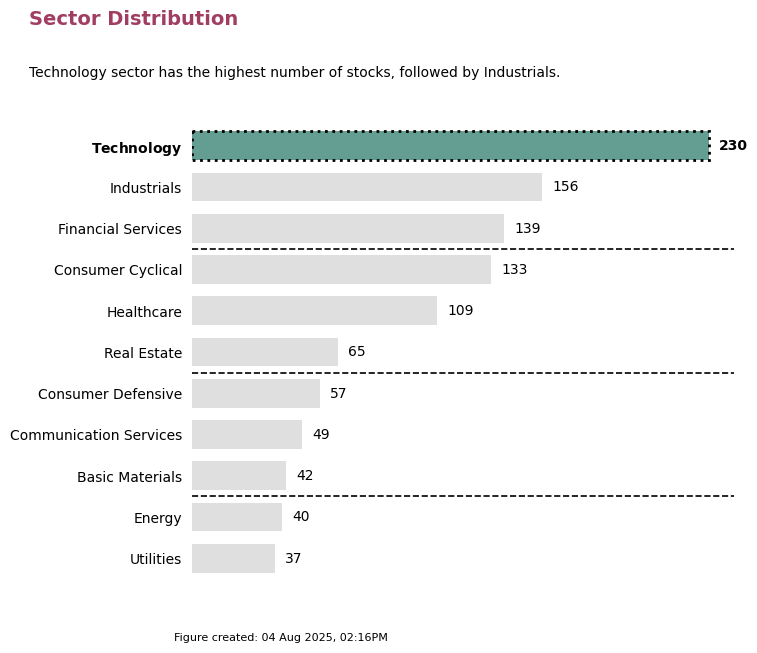

In [7]:
import datetime
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique sector counts
temp_df = stock_info_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the sector with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, sector in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'sector_distribution.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

In [8]:
selected_sector = 'Technology'
selected_sector_symbols = stock_info_df['symbol'][stock_info_df['sector'] == selected_sector]
#selected_sector_symbols =['AEE', 'AEP', 'AES', 'ATO']
selected_sector_symbols =['AEE', 'AEP']
ohlc_df = stock_data_df[stock_data_df['symbol'].isin(selected_sector_symbols)]
ohlc_df = ohlc_df.drop(columns=['source'])

In [9]:
ohlc_df.columns

Index(['timestamp', 'symbol', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

# CELL 4: Explore the Data

In [10]:
print("Basic statistics by symbol:")
print(ohlc_df.groupby('symbol')[['open', 'high', 'low', 'close', 'volume']].describe())

Basic statistics by symbol:
          open                                                            \
         count        mean       std    min       25%       50%      75%   
symbol                                                                     
AEE     1738.0   92.729839  5.902839  79.77  87.89625   94.5200   97.710   
AEP     1738.0  101.234210  4.639652  90.10  98.07500  101.7075  104.284   

                  high              ...     close          volume  \
           max   count        mean  ...       75%     max   count   
symbol                              ...                             
AEE     103.79  1738.0   93.008659  ...   97.7175  103.71  1738.0   
AEP     114.36  1738.0  101.531712  ...  104.3700  113.89  1738.0   

                                                                              \
                 mean            std      min       25%       50%        75%   
symbol                                                                         
AEE  

In [11]:
import math
num_symbols = len(selected_sector_symbols)
# Determine grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_symbols / cols)

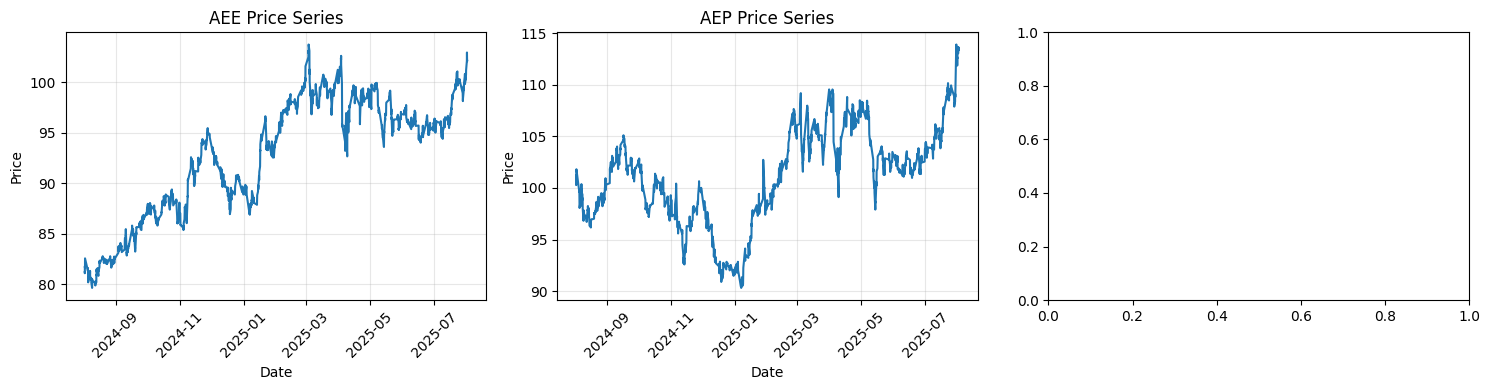

In [12]:
# Plot price series for all symbols
#fig, axes = plt.subplots(4, figsize=(15, 10))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

for i, symbol in enumerate(ohlc_df['symbol'].unique()):
    symbol_data = ohlc_df[ohlc_df['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('timestamp')
    
    axes[i].plot(symbol_data['timestamp'], symbol_data['close'], label=f'{symbol} Close Price')
    axes[i].set_title(f'{symbol} Price Series')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# CELL 5: Feature Engineering

In [13]:
import numpy as np
import pandas as pd

def engineer_features(df):
    """Create technical indicators and features from hourly OHLC data"""
    
    print("Engineering features for hourly data...")
    features_df = df.copy()
    
    # Window sizes for hourly data
    short_window = 24        # 1 day
    med_window = 120         # 5 days  
    long_window = 480        # 20 days
    vol_windows = [12, 24, 120]  # 12h, 1d, 5d
    rsi_windows = {
        'rsi_1d': 24,        # 1 day
        'rsi_3d': 72,        # 3 days
        'rsi_1w': 168,       # 1 week
        'rsi_2w': 336        # 2 weeks (traditional 14-day equivalent)
    }
    
    def create_features_for_symbol(group):
        group = group.sort_values('timestamp').copy()
        
        print(f"Processing {group['symbol'].iloc[0]}...")
        
        # Basic price features
        group['returns'] = group['close'].pct_change()
        group['log_returns'] = np.log(group['close'] / group['close'].shift(1))
        group['high_low_pct'] = (group['high'] - group['low']) / group['close']
        group['open_close_pct'] = (group['close'] - group['open']) / group['open']
        
        # Volatility features (realized volatility)
        group['returns_squared'] = group['returns'] ** 2
        group['realized_vol_short'] = group['returns'].rolling(vol_windows[0]).std()
        group['realized_vol_med'] = group['returns'].rolling(vol_windows[1]).std()
        group['realized_vol_long'] = group['returns'].rolling(vol_windows[2]).std()
        
        # Moving averages and ratios
        group['price_ma_short'] = group['close'].rolling(short_window).mean()
        group['price_ma_med'] = group['close'].rolling(med_window).mean()
        group['price_ma_long'] = group['close'].rolling(long_window).mean()
        group['price_to_ma_short'] = group['close'] / group['price_ma_short']
        group['price_to_ma_med'] = group['close'] / group['price_ma_med']
        group['price_to_ma_long'] = group['close'] / group['price_ma_long']
        
        # Volume features
        group['volume_ma'] = group['volume'].rolling(med_window).mean()
        group['volume_ratio'] = group['volume'] / group['volume_ma']
        group['log_volume'] = np.log(group['volume'] + 1)  # Add 1 to avoid log(0)
        
        # Multiple RSI timeframes
        for rsi_name, window in rsi_windows.items():
            delta = group['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
            rs = gain / (loss + 1e-10)  # Add small epsilon to avoid division by zero
            group[rsi_name] = 100 - (100 / (1 + rs))
        
        # Exponential Moving Average RSI (more responsive)
        delta = group['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        alpha = 2 / (14 + 1)  # Traditional 14-period smoothing
        avg_gain = gain.ewm(alpha=alpha, adjust=False).mean()
        avg_loss = loss.ewm(alpha=alpha, adjust=False).mean()
        rs_ema = avg_gain / (avg_loss + 1e-10)
        group['rsi_ema'] = 100 - (100 / (1 + rs_ema))
        
        # Time-based features for hourly data
        group['hour'] = group['timestamp'].dt.hour
        group['day_of_week'] = group['timestamp'].dt.dayofweek
        group['date'] = group['timestamp'].dt.date
        
        # Market session features
        group['is_market_open'] = ((group['hour'] >= 9) & (group['hour'] <= 16)).astype(int)
        group['is_morning'] = ((group['hour'] >= 9) & (group['hour'] <= 12)).astype(int)
        group['is_afternoon'] = ((group['hour'] >= 13) & (group['hour'] <= 16)).astype(int)
        group['hours_since_open'] = np.clip(group['hour'] - 9, 0, 7)  # 0-7 hours
        group['hours_to_close'] = np.clip(16 - group['hour'], 0, 7)   # 0-7 hours
        
        # Daily reference points (with proper handling)
        try:
            # Daily opens - first open of each trading day
            daily_opens = group.groupby('date')['open'].transform('first')
            group['returns_from_daily_open'] = ((group['close'] - daily_opens) / 
                                               daily_opens).fillna(0)
            
            # Intraday high/low for each day
            group['intraday_high'] = group.groupby('date')['high'].transform('max')
            group['intraday_low'] = group.groupby('date')['low'].transform('min')
            
            # Avoid division by zero in intraday range
            intraday_range = group['intraday_high'] - group['intraday_low']
            group['intraday_range_pct'] = (intraday_range / daily_opens).fillna(0)
            
            # Position within intraday range (0 = at low, 1 = at high)
            range_denominator = intraday_range.replace(0, np.nan)  # Replace 0 with NaN
            group['position_in_range'] = ((group['close'] - group['intraday_low']) / 
                                         range_denominator).fillna(0.5)  # Default to middle
            
            # Previous day's close for gap analysis
            prev_day_close = (group.groupby('date')['close']
                             .transform('last')
                             .shift(group.groupby('date').cumcount().max() + 1))
            group['overnight_gap'] = ((daily_opens - prev_day_close) / 
                                    prev_day_close).fillna(0)
            
            # Intraday momentum features
            group['dist_from_intraday_high'] = ((group['close'] - group['intraday_high']) / 
                                               group['intraday_high']).fillna(0)
            group['dist_from_intraday_low'] = ((group['close'] - group['intraday_low']) / 
                                              group['intraday_low']).fillna(0)
            
        except Exception as e:
            print(f"Warning: Error in intraday features for {group['symbol'].iloc[0]}: {e}")
            # Create dummy features if calculation fails
            group['returns_from_daily_open'] = 0
            group['intraday_range_pct'] = 0
            group['position_in_range'] = 0.5
            group['overnight_gap'] = 0
            group['dist_from_intraday_high'] = 0
            group['dist_from_intraday_low'] = 0
        
        # Lagged features for hourly data
        lag_periods = [1, 2, 4, 8, 24]  # 1h, 2h, 4h, 8h, 1day
            
        for lag in lag_periods:
            group[f'returns_lag_{lag}'] = group['returns'].shift(lag)
            group[f'vol_lag_{lag}'] = group['realized_vol_short'].shift(lag)
        
        # Technical indicators
        # Bollinger Bands
        bb_window = short_window
        bb_std = group['close'].rolling(bb_window).std()
        bb_mean = group['close'].rolling(bb_window).mean()
        group['bb_upper'] = bb_mean + (2 * bb_std)
        group['bb_lower'] = bb_mean - (2 * bb_std)
        group['bb_position'] = ((group['close'] - group['bb_lower']) / 
                               (group['bb_upper'] - group['bb_lower'] + 1e-10)).fillna(0.5)
        
        # MACD
        exp1 = group['close'].ewm(span=12).mean()
        exp2 = group['close'].ewm(span=26).mean()
        group['macd'] = exp1 - exp2
        group['macd_signal'] = group['macd'].ewm(span=9).mean()
        group['macd_histogram'] = group['macd'] - group['macd_signal']
        
        return group
    
    # Apply feature engineering to each symbol
    features_df = features_df.groupby('symbol').apply(create_features_for_symbol).reset_index(drop=True)
    
    # Remove rows with NaN values
    initial_rows = len(features_df)
    features_df = features_df.dropna()
    print(f"\nRemoved {initial_rows - len(features_df)} rows with NaN values")
    
    # Identify feature columns (exclude OHLCV and metadata)
    exclude_cols = ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 
                   'hour', 'day_of_week', 'date']
    
    feature_cols = [col for col in features_df.columns if col not in exclude_cols]
    
    print(f"\nCreated {len(feature_cols)} features:")
    for i, col in enumerate(feature_cols):
        if i % 4 == 0:
            print()
        print(f"{col:25}", end=" ")
    print()
    
    # Feature summary statistics
    print(f"\nFeature summary:")
    print(f"Total features: {len(feature_cols)}")
    print(f"Price features: {len([c for c in feature_cols if 'price' in c or 'returns' in c])}")
    print(f"Volatility features: {len([c for c in feature_cols if 'vol' in c])}")
    print(f"Volume features: {len([c for c in feature_cols if 'volume' in c])}")
    print(f"Technical indicators: {len([c for c in feature_cols if any(x in c for x in ['rsi', 'macd', 'bb'])])}")
    print(f"Intraday features: {len([c for c in feature_cols if any(x in c for x in ['intraday', 'daily_open', 'position_in_range'])])}")
    print(f"Lagged features: {len([c for c in feature_cols if 'lag' in c])}")
    
    return features_df, feature_cols

In [14]:
# Engineer features
features_df, feature_columns = engineer_features(ohlc_df)

Engineering features for hourly data...
Processing AEE...
Processing AEP...

Removed 958 rows with NaN values

Created 51 features:

returns                   log_returns               high_low_pct              open_close_pct            
returns_squared           realized_vol_short        realized_vol_med          realized_vol_long         
price_ma_short            price_ma_med              price_ma_long             price_to_ma_short         
price_to_ma_med           price_to_ma_long          volume_ma                 volume_ratio              
log_volume                rsi_1d                    rsi_3d                    rsi_1w                    
rsi_2w                    rsi_ema                   is_market_open            is_morning                
is_afternoon              hours_since_open          hours_to_close            returns_from_daily_open   
intraday_high             intraday_low              intraday_range_pct        position_in_range         
overnight_gap             d

In [15]:
print(f"\nFeatures DataFrame shape: {features_df.shape}")
print(f"Available symbols: {features_df['symbol'].unique()}")


Features DataFrame shape: (2518, 61)
Available symbols: ['AEE' 'AEP']


# CELL 6: Visualize Some Key Features

In [16]:
# Plot some key features for one symbol
sample_symbol = 'AEE'
sample_data = features_df[features_df['symbol'] == sample_symbol].copy()
sample_data = sample_data.sort_values('timestamp')

sample_data.head(5)

,timestamp,symbol,open,high,low,close,volume,returns,log_returns,high_low_pct,...,returns_lag_8,vol_lag_8,returns_lag_24,vol_lag_24,bb_upper,bb_lower,bb_position,macd,macd_signal,macd_histogram
479,2024-11-07 11:00:00,AEE,86.60,86.79,85.70,86.050,253670,-0.006351,-0.006371,0.012667,...,0.002638,0.002904,-0.003726,0.002507,88.448042,85.172374,0.267923,0.076398,0.184071,-0.107674
480,2024-11-07 12:00:00,AEE,86.09,86.96,86.06,86.715,367462,0.007728,0.007698,0.010379,...,0.005034,0.002858,-0.002279,0.002467,88.386196,85.346304,0.450245,0.042977,0.155852,-0.112875
481,2024-11-07 13:00:00,AEE,86.75,87.08,86.52,86.910,305794,0.002249,0.002246,0.006443,...,-0.001935,0.002937,0.001933,0.002485,88.333739,85.513344,0.495199,0.031859,0.131054,-0.099195
482,2024-11-07 14:00:00,AEE,86.94,87.00,86.53,86.540,708564,-0.004257,-0.004266,0.005431,...,0.002395,0.002803,0.000643,0.002514,88.266361,85.659889,0.337664,-0.006731,0.103497,-0.110228
483,2024-11-08 08:00:00,AEE,87.08,88.84,86.69,88.710,147265,0.025075,0.024766,0.024236,...,-0.001252,0.002763,0.002220,0.002411,88.472105,85.698312,1.085765,0.136217,0.110041,0.026176


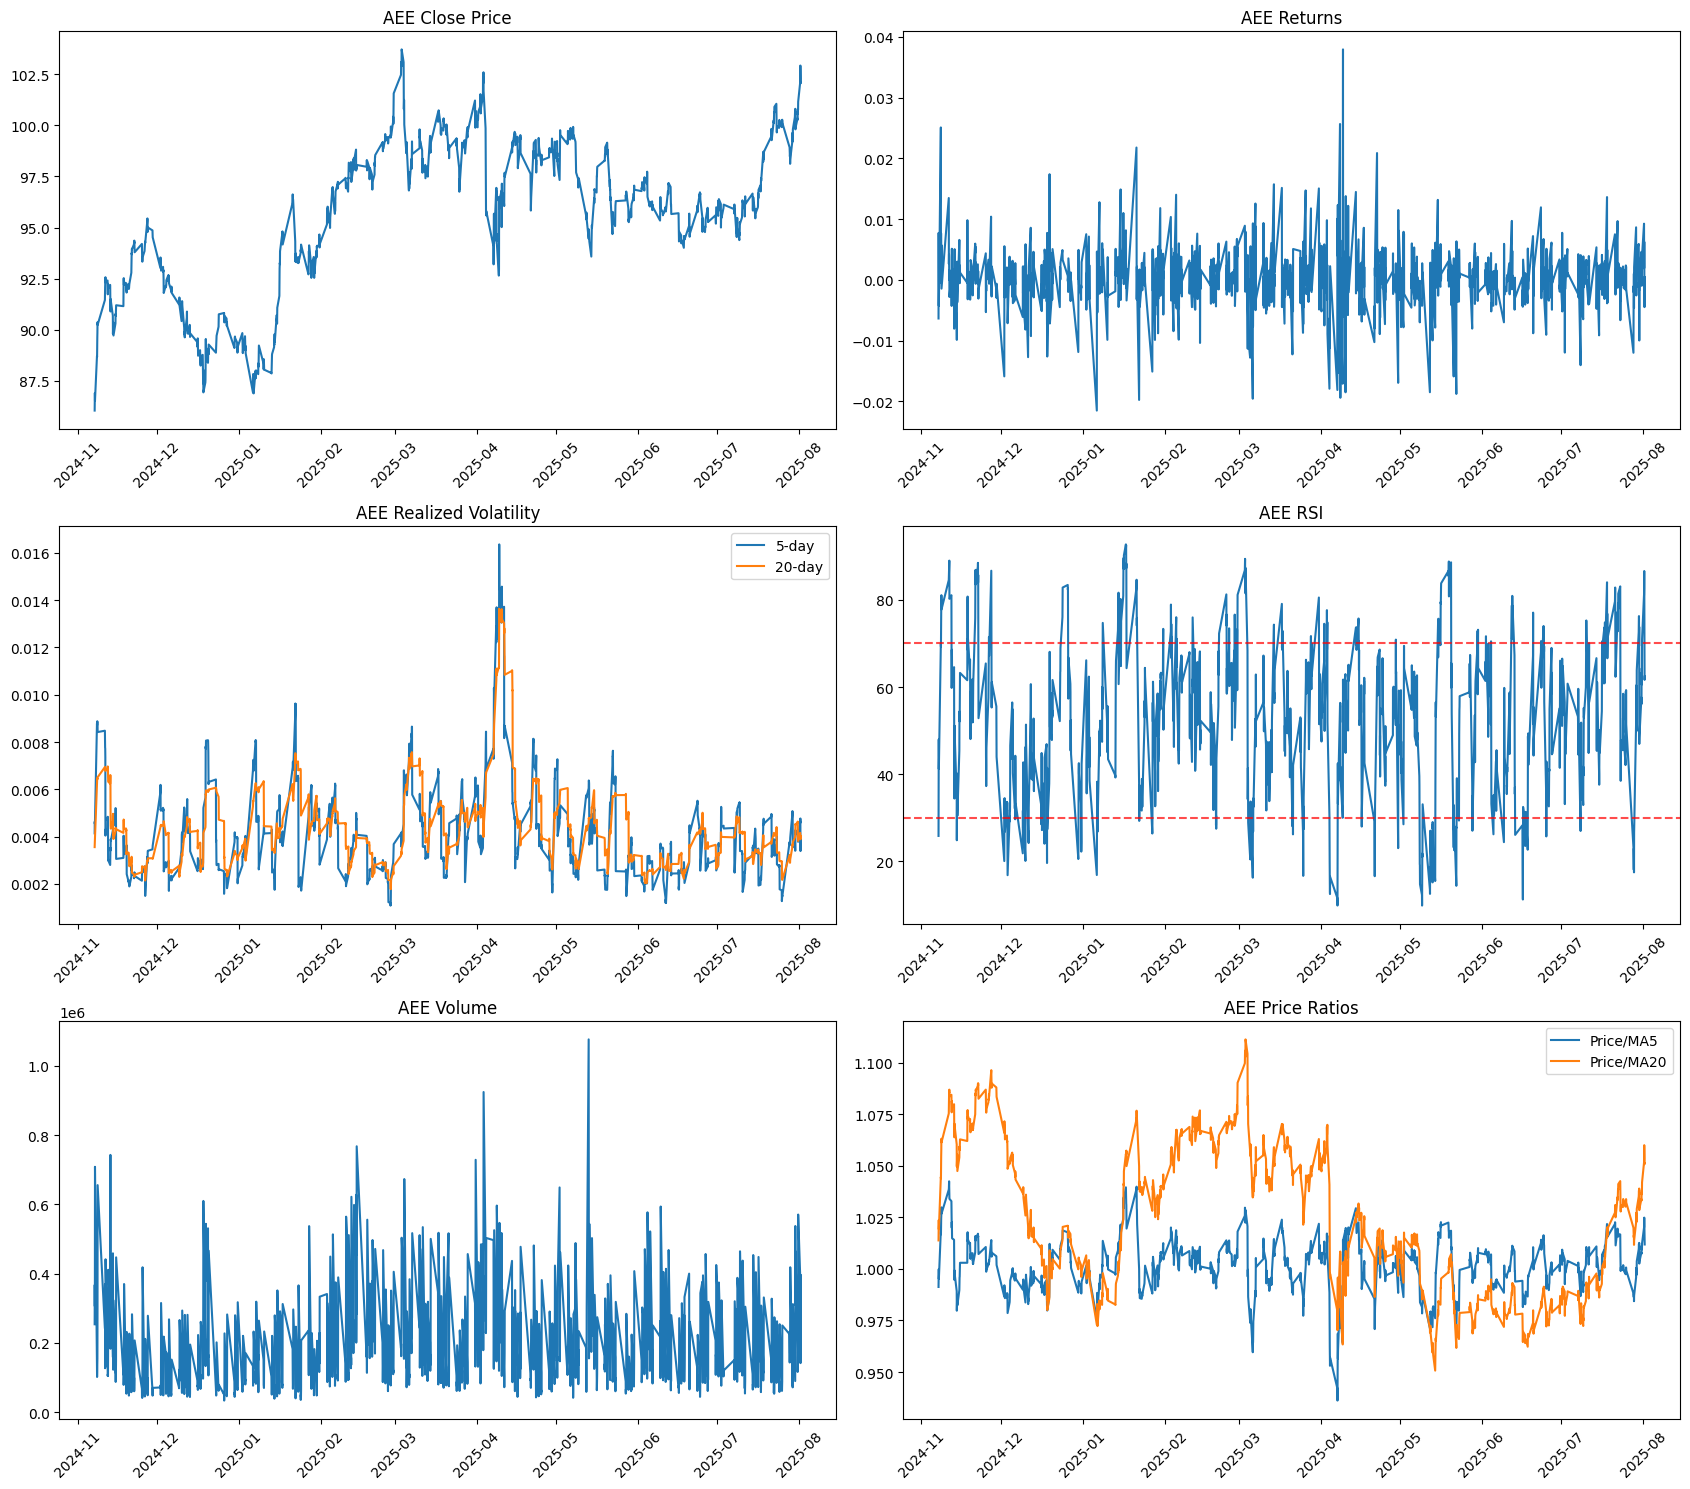

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(17, 15))
#fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Price and returns
axes[0,0].plot(sample_data['timestamp'], sample_data['close'])
axes[0,0].set_title(f'{sample_symbol} Close Price')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(sample_data['timestamp'], sample_data['returns'])
axes[0,1].set_title(f'{sample_symbol} Returns')
axes[0,1].tick_params(axis='x', rotation=45)

# Volatility
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_short'], label='5-day')
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_med'], label='20-day')
axes[1,0].set_title(f'{sample_symbol} Realized Volatility')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# RSI
axes[1,1].plot(sample_data['timestamp'], sample_data['rsi_ema'])
axes[1,1].axhline(y=70, color='r', linestyle='--', alpha=0.7)
axes[1,1].axhline(y=30, color='r', linestyle='--', alpha=0.7)
axes[1,1].set_title(f'{sample_symbol} RSI')
axes[1,1].tick_params(axis='x', rotation=45)

# Volume
axes[2,0].plot(sample_data['timestamp'], sample_data['volume'])
axes[2,0].set_title(f'{sample_symbol} Volume')
axes[2,0].tick_params(axis='x', rotation=45)

# Price ratios
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_short'], label='Price/MA5')
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_long'], label='Price/MA20')
axes[2,1].set_title(f'{sample_symbol} Price Ratios')
axes[2,1].legend()
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# CELL 7: Create Sequences for Training

In [18]:
def create_sequences(df, feature_cols, sequence_length=48, target_col='realized_vol_short', 
                    target_horizon=6, timeframe='hourly'):
    """Convert tabular data to sequences for RNN training
    
    Args:
        df: DataFrame with features
        feature_cols: List of feature column names
        sequence_length: Length of input sequences (hours for hourly data)
        target_col: Target column name
        target_horizon: How many periods ahead to predict
        timeframe: 'hourly' or 'daily' to adjust parameters
    """
    
    print(f"Creating sequences for {timeframe} data with length {sequence_length}...")
    print(f"Target: {target_col} with horizon {target_horizon}")
    
    # Adjust timestamp column name (assuming hourly data uses 'timestamp')
    time_col = 'timestamp' if timeframe == 'hourly' else 'date'
    
    all_sequences = []
    all_returns_sequences = []
    all_targets = []
    all_symbols = []
    all_timestamps = []  # Track timestamps for analysis
    
    for symbol in df['symbol'].unique():
        symbol_data = df[df['symbol'] == symbol].sort_values(time_col).copy()
        
        if len(symbol_data) < sequence_length + target_horizon:
            print(f"Skipping {symbol}: insufficient data ({len(symbol_data)} rows)")
            continue
        
        print(f"Processing {symbol}: {len(symbol_data)} rows")
        
        # Extract features and targets
        features = symbol_data[feature_cols].values
        returns = symbol_data['log_returns'].values
        targets = symbol_data[target_col].values
        timestamps = symbol_data[time_col].values
        
        # Create sequences
        n_sequences = len(symbol_data) - sequence_length - target_horizon + 1
        
        for i in range(n_sequences):
            # Input sequence (features and returns)
            seq_features = features[i:i+sequence_length]
            seq_returns = returns[i:i+sequence_length]
            
            # Target (volatility at horizon ahead)
            target_vol = targets[i + sequence_length + target_horizon - 1]
            target_timestamp = timestamps[i + sequence_length + target_horizon - 1]
            
            # Skip if target is NaN
            if np.isnan(target_vol):
                continue
                
            all_sequences.append(seq_features)
            all_returns_sequences.append(seq_returns)
            all_targets.append(target_vol)
            all_symbols.append(symbol)
            all_timestamps.append(target_timestamp)
    
    print(f"\nCreated {len(all_sequences)} sequences from {len(df['symbol'].unique())} symbols")
    
    # Calculate time coverage
    if timeframe == 'hourly':
        sequence_hours = sequence_length
        horizon_hours = target_horizon
        print(f"Each sequence covers {sequence_hours} hours ({sequence_hours/24:.1f} days)")
        print(f"Predicting {horizon_hours} hours ({horizon_hours/24:.1f} days) ahead")
    else:
        print(f"Each sequence covers {sequence_length} days")
        print(f"Predicting {target_horizon} days ahead")
    
    return {
        'sequences': np.array(all_sequences),
        'returns_sequences': np.array(all_returns_sequences),
        'targets': np.array(all_targets),
        'symbols': all_symbols,
        'timestamps': all_timestamps
    }

In [19]:
# Recommended parameters for hourly data
#if timeframe == 'hourly':
    # Option 1: Short-term prediction (intraday)
SEQUENCE_LENGTH = 48      # 2 days of history
TARGET_HORIZON = 6        # Predict 6 hours ahead
TARGET_COL = 'realized_vol_short'  # Use shorter volatility window
    
    # Option 2: Medium-term prediction (next day)
    # SEQUENCE_LENGTH = 120     # 5 days of history  
    # TARGET_HORIZON = 24       # Predict 1 day ahead
    # TARGET_COL = 'realized_vol_med'
    
    # Option 3: Longer-term prediction
    # SEQUENCE_LENGTH = 240     # 10 days of history
    # TARGET_HORIZON = 48       # Predict 2 days ahead
    # TARGET_COL = 'realized_vol_long'
    
#else:  # daily data
    #SEQUENCE_LENGTH = 20
    #TARGET_HORIZON = 1
    #TARGET_COL = 'realized_vol_5'

# Create sequences with appropriate parameters
print(f"Using sequence length: {SEQUENCE_LENGTH}")
print(f"Using target horizon: {TARGET_HORIZON}")
print(f"Using target column: {TARGET_COL}")

sequence_data = create_sequences(
    features_df, 
    feature_columns, 
    sequence_length=SEQUENCE_LENGTH,
    target_col=TARGET_COL,
    target_horizon=TARGET_HORIZON,
    timeframe='hourly'  # or 'daily'
)

print(f"\nSequence shapes:")
print(f"Features: {sequence_data['sequences'].shape}")
print(f"Returns: {sequence_data['returns_sequences'].shape}")
print(f"Targets: {sequence_data['targets'].shape}")
print(f"Symbols: {len(sequence_data['symbols'])}")

Using sequence length: 48
Using target horizon: 6
Using target column: realized_vol_short
Creating sequences for hourly data with length 48...
Target: realized_vol_short with horizon 6
Processing AEE: 1259 rows
Processing AEP: 1259 rows

Created 2412 sequences from 2 symbols
Each sequence covers 48 hours (2.0 days)
Predicting 6 hours (0.2 days) ahead

Sequence shapes:
Features: (2412, 48, 51)
Returns: (2412, 48)
Targets: (2412,)
Symbols: 2412


In [20]:
# Additional analysis for hourly data
#if timeframe == 'hourly':
print(f"\nHourly data analysis:")
print(f"Total sequences: {len(sequence_data['sequences'])}")
print(f"Each sequence: {SEQUENCE_LENGTH} hours = {SEQUENCE_LENGTH/24:.1f} days")
print(f"Prediction horizon: {TARGET_HORIZON} hours = {TARGET_HORIZON/24:.1f} days")

# Check data distribution across hours/days
timestamps = pd.to_datetime(sequence_data['timestamps'])
print(f"Time range: {timestamps.min()} to {timestamps.max()}")
print(f"Unique hours: {sorted(timestamps.hour.unique())}")
print(f"Unique days: {len(np.unique(timestamps.date))}")


Hourly data analysis:
Total sequences: 2412
Each sequence: 48 hours = 2.0 days
Prediction horizon: 6 hours = 0.2 days
Time range: 2024-11-19 08:00:00 to 2025-08-01 14:00:00
Unique hours: [8, 9, 10, 11, 12, 13, 14]
Unique days: 174


# CELL 8: Train/Validation/Test Split

In [21]:
def create_data_splits(data_dict, test_size=0.2, val_size=0.2, random_state=42):
    """Split data maintaining symbol distribution"""
    
    sequences = data_dict['sequences']
    returns_sequences = data_dict['returns_sequences']
    targets = data_dict['targets']
    symbols = data_dict['symbols']
    
    print("Creating data splits...")
    print(f"Total samples: {len(sequences)}")
    
    # First split: train+val vs test
    train_val_seq, test_seq, train_val_ret, test_ret, train_val_tgt, test_tgt, train_val_sym, test_sym = \
        train_test_split(sequences, returns_sequences, targets, symbols, 
                        test_size=test_size, random_state=random_state, stratify=symbols)
    
    # Second split: train vs val  
    val_size_adjusted = val_size / (1 - test_size)
    train_seq, val_seq, train_ret, val_ret, train_tgt, val_tgt, train_sym, val_sym = \
        train_test_split(train_val_seq, train_val_ret, train_val_tgt, train_val_sym,
                        test_size=val_size_adjusted, random_state=random_state, stratify=train_val_sym)
    
    print(f"Train: {len(train_seq)} samples")
    print(f"Validation: {len(val_seq)} samples")
    print(f"Test: {len(test_seq)} samples")
    
    # Check symbol distribution
    print("\nSymbol distribution:")
    for split_name, split_symbols in [('Train', train_sym), ('Val', val_sym), ('Test', test_sym)]:
        symbol_counts = pd.Series(split_symbols).value_counts()
        print(f"{split_name}: {dict(symbol_counts)}")
    
    return {
        'train': {'sequences': train_seq, 'returns': train_ret, 'targets': train_tgt, 'symbols': train_sym},
        'val': {'sequences': val_seq, 'returns': val_ret, 'targets': val_tgt, 'symbols': val_sym},
        'test': {'sequences': test_seq, 'returns': test_ret, 'targets': test_tgt, 'symbols': test_sym}
    }

In [22]:
# Create splits
data_splits = create_data_splits(sequence_data, test_size=0.2, val_size=0.2)

Creating data splits...
Total samples: 2412
Train: 1446 samples
Validation: 483 samples
Test: 483 samples

Symbol distribution:
Train: {'AEP': np.int64(723), 'AEE': np.int64(723)}
Val: {'AEP': np.int64(242), 'AEE': np.int64(241)}
Test: {'AEE': np.int64(242), 'AEP': np.int64(241)}


In [23]:
# Check the actual sequence order in your splits
train_symbols = data_splits['train']['symbols']
print("First 20 train symbols:", train_symbols[:20])
print("Last 20 train symbols:", train_symbols[-20:])

# Should see mixed AEP/AEE, not blocks

First 20 train symbols: ['AEP', 'AEP', 'AEE', 'AEE', 'AEE', 'AEE', 'AEP', 'AEE', 'AEP', 'AEP', 'AEP', 'AEE', 'AEP', 'AEE', 'AEE', 'AEP', 'AEP', 'AEE', 'AEP', 'AEE']
Last 20 train symbols: ['AEE', 'AEE', 'AEE', 'AEP', 'AEP', 'AEE', 'AEE', 'AEE', 'AEE', 'AEE', 'AEP', 'AEP', 'AEE', 'AEP', 'AEE', 'AEP', 'AEP', 'AEP', 'AEE', 'AEE']


#  CELL 9: Feature Scaling

In [24]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

def scale_data_complete(data_splits):
    """Scale features, returns, and targets for volatility prediction"""
    
    print("Scaling features, returns, and targets...")
    
    # Extract data from splits
    train_sequences = data_splits['train']['sequences']
    val_sequences = data_splits['val']['sequences']
    test_sequences = data_splits['test']['sequences']
    
    train_returns = data_splits['train']['returns']
    val_returns = data_splits['val']['returns']
    test_returns = data_splits['test']['returns']
    
    train_targets = data_splits['train']['targets']
    val_targets = data_splits['val']['targets']
    test_targets = data_splits['test']['targets']
    
    # 1. Scale feature sequences
    print("Scaling feature sequences...")
    train_reshaped = train_sequences.reshape(-1, train_sequences.shape[-1])
    
    feature_scaler = StandardScaler()
    train_scaled_reshaped = feature_scaler.fit_transform(train_reshaped)
    train_scaled = train_scaled_reshaped.reshape(train_sequences.shape)
    
    # Transform validation and test sets
    val_reshaped = val_sequences.reshape(-1, val_sequences.shape[-1])
    val_scaled_reshaped = feature_scaler.transform(val_reshaped)
    val_scaled = val_scaled_reshaped.reshape(val_sequences.shape)
    
    test_reshaped = test_sequences.reshape(-1, test_sequences.shape[-1])
    test_scaled_reshaped = feature_scaler.transform(test_reshaped)
    test_scaled = test_scaled_reshaped.reshape(test_sequences.shape)
    
    # 2. Scale returns sequences
    print("Scaling returns sequences...")
    train_returns_reshaped = train_returns.reshape(-1, 1)
    returns_scaler = StandardScaler()
    train_returns_scaled = returns_scaler.fit_transform(train_returns_reshaped).reshape(train_returns.shape)
    
    val_returns_scaled = returns_scaler.transform(val_returns.reshape(-1, 1)).reshape(val_returns.shape)
    test_returns_scaled = returns_scaler.transform(test_returns.reshape(-1, 1)).reshape(test_returns.shape)
    
    # 3. Scale target volatilities
    print("Scaling target volatilities...")
    target_scaler = StandardScaler()
    train_targets_scaled = target_scaler.fit_transform(train_targets.reshape(-1, 1)).ravel()
    val_targets_scaled = target_scaler.transform(val_targets.reshape(-1, 1)).ravel()
    test_targets_scaled = target_scaler.transform(test_targets.reshape(-1, 1)).ravel()
    
    # Print scaling statistics
    print(f"\nScaling Statistics:")
    print(f"Features - first 5 means: {feature_scaler.mean_[:5]}")
    print(f"Features - first 5 stds: {feature_scaler.scale_[:5]}")
    print(f"Returns - mean: {returns_scaler.mean_[0]:.6f}, std: {returns_scaler.scale_[0]:.6f}")
    print(f"Targets - mean: {target_scaler.mean_[0]:.6f}, std: {target_scaler.scale_[0]:.6f}")
    
    # 4. Convert to PyTorch tensors
    print("Converting to PyTorch tensors...")
    train_data = {
        'sequences': torch.FloatTensor(train_scaled),
        'returns': torch.FloatTensor(train_returns_scaled),
        'targets': torch.FloatTensor(train_targets_scaled),
        'symbols': data_splits['train']['symbols']
    }
    
    val_data = {
        'sequences': torch.FloatTensor(val_scaled),
        'returns': torch.FloatTensor(val_returns_scaled),
        'targets': torch.FloatTensor(val_targets_scaled),
        'symbols': data_splits['val']['symbols']
    }
    
    test_data = {
        'sequences': torch.FloatTensor(test_scaled),
        'returns': torch.FloatTensor(test_returns_scaled),
        'targets': torch.FloatTensor(test_targets_scaled),
        'symbols': data_splits['test']['symbols']
    }
    
    # 5. Create scalers dictionary for later use
    scalers = {
        'features': feature_scaler,
        'returns': returns_scaler,
        'targets': target_scaler
    }
    
    print(f"\nTensor shapes:")
    print(f"Train sequences: {train_data['sequences'].shape}")
    print(f"Train returns: {train_data['returns'].shape}")
    print(f"Train targets: {train_data['targets'].shape}")
    print(f"Val sequences: {val_data['sequences'].shape}")
    print(f"Test sequences: {test_data['sequences'].shape}")
    
    return train_data, val_data, test_data, scalers

In [25]:
# Usage
train_data, val_data, test_data, scalers = scale_data_complete(data_splits)

Scaling features, returns, and targets...
Scaling feature sequences...
Scaling returns sequences...
Scaling target volatilities...

Scaling Statistics:
Features - first 5 means: [1.11031409e-04 9.95775436e-05 6.23020040e-03 9.62994171e-05
 2.29326725e-05]
Features - first 5 stds: [4.78751966e-03 4.78395367e-03 4.34285902e-03 4.47674905e-03
 6.90670307e-05]
Returns - mean: 0.000100, std: 0.004784
Targets - mean: 0.004306, std: 0.002043
Converting to PyTorch tensors...

Tensor shapes:
Train sequences: torch.Size([1446, 48, 51])
Train returns: torch.Size([1446, 48])
Train targets: torch.Size([1446])
Val sequences: torch.Size([483, 48, 51])
Test sequences: torch.Size([483, 48, 51])


In [26]:
# Optional: Check for any scaling issues
print(f"\nData quality checks:")
print(f"Train sequences - min: {train_data['sequences'].min():.3f}, max: {train_data['sequences'].max():.3f}")
print(f"Train returns - min: {train_data['returns'].min():.3f}, max: {train_data['returns'].max():.3f}")
print(f"Train targets - min: {train_data['targets'].min():.3f}, max: {train_data['targets'].max():.3f}")


Data quality checks:
Train sequences - min: -8.744, max: 20.480
Train returns - min: -4.585, max: 7.758
Train targets - min: -1.569, max: 5.816


In [27]:
# Check for NaN values
if torch.isnan(train_data['sequences']).any():
    print("⚠️  Warning: NaN values found in scaled sequences!")
if torch.isnan(train_data['targets']).any():
    print("⚠️  Warning: NaN values found in scaled targets!")

In [28]:
# For model evaluation, you'll need to inverse transform predictions:
def inverse_transform_predictions(predictions, scaler):
    """Convert scaled predictions back to original scale"""
    return scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()

# Example usage during evaluation:
# predictions_original_scale = inverse_transform_predictions(model_predictions, scalers['targets'])

print("Scaling completed successfully!")
print(f"Scalers saved for: {list(scalers.keys())}")

Scaling completed successfully!
Scalers saved for: ['features', 'returns', 'targets']


# CELL 2: GARCH-GRU Model Components

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, Union

class GARCHGRUCell(nn.Module):
    """Custom GRU cell with integrated GARCH(1,1) volatility dynamics optimized for hourly data"""
    
    def __init__(self, input_size: int, hidden_size: int, 
                 learn_garch_params: bool = True,
                 # Adjusted initial parameters for hourly data
                 initial_omega: float = 0.001,     # Lower baseline volatility for hourly
                 initial_alpha: float = 0.05,      # Lower shock persistence for hourly
                 initial_beta: float = 0.92,       # Higher persistence for hourly
                 gamma_init: float = 0.15):        # Slightly higher volatility integration
        super(GARCHGRUCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Standard GRU parameters
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(3 * hidden_size))
        
        # GARCH parameters with hourly-appropriate initialization
        if learn_garch_params:
            self.log_omega = nn.Parameter(torch.log(torch.tensor(initial_omega)))
            self.log_alpha = nn.Parameter(torch.log(torch.tensor(initial_alpha)))
            self.log_beta = nn.Parameter(torch.log(torch.tensor(initial_beta)))
        else:
            self.register_buffer('log_omega', torch.log(torch.tensor(initial_omega)))
            self.register_buffer('log_alpha', torch.log(torch.tensor(initial_alpha)))
            self.register_buffer('log_beta', torch.log(torch.tensor(initial_beta)))
        
        # Enhanced volatility integration for hourly patterns
        self.volatility_proj = nn.Linear(1, hidden_size)
        self.gamma = nn.Parameter(torch.tensor(gamma_init))
        
        # Additional hourly-specific components
        self.intraday_gate = nn.Linear(hidden_size + 1, hidden_size)  # Gate for intraday effects
        
        self.reset_parameters()
    
    def reset_parameters(self):
        std = 1.0 / (self.hidden_size)
        for name, weight in self.named_parameters():
            if weight.dim() > 1:
                torch.nn.init.xavier_uniform_(weight)
            else:
                weight.data.uniform_(-std, std)
                
        # Special initialization for GARCH parameters to ensure reasonable starting values
        with torch.no_grad():
            # Ensure starting values are in reasonable ranges for hourly data
            self.log_omega.data = torch.log(torch.tensor(0.001))  # Very small baseline
            self.log_alpha.data = torch.log(torch.tensor(0.05))   # Small shock effect
            self.log_beta.data = torch.log(torch.tensor(0.92))    # High persistence
    
    def get_garch_params(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        omega = torch.exp(self.log_omega)
        alpha = torch.exp(self.log_alpha)
        beta = torch.exp(self.log_beta)
        
        # Stricter stationarity constraint for hourly data
        alpha_beta_sum = alpha + beta
        if alpha_beta_sum >= 0.998:  # More conservative for hourly
            scale_factor = 0.995 / alpha_beta_sum
            alpha = alpha * scale_factor
            beta = beta * scale_factor
            
        return omega, alpha, beta
    
    def update_garch_variance(self, returns: torch.Tensor, 
                            prev_variance: torch.Tensor,
                            prev_error: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        omega, alpha, beta = self.get_garch_params()
        
        # Enhanced GARCH for hourly data with microstructure effects
        microstructure_noise = 1e-6  # Small noise term for hourly data
        current_variance = (omega + alpha * (prev_error ** 2) + 
                          beta * prev_variance + microstructure_noise)
        
        # Ensure minimum variance for numerical stability in hourly data
        current_variance = torch.clamp(current_variance, min=1e-8, max=1.0)
        current_error = returns
        
        return current_variance, current_error
    
    def forward(self, input: torch.Tensor, hidden: torch.Tensor,
                prev_variance: torch.Tensor, prev_error: torch.Tensor,
                returns: torch.Tensor, hour_features: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        
        batch_size = input.size(0)
        
        # Standard GRU operations
        gi = F.linear(input, self.weight_ih, self.bias_ih)
        gh = F.linear(hidden, self.weight_hh, self.bias_hh)
        i_r, i_i, i_n = gi.chunk(3, 1)
        h_r, h_i, h_n = gh.chunk(3, 1)
        
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + resetgate * h_n)
        h_hat = (1 - inputgate) * hidden + inputgate * newgate
        
        # Update GARCH variance
        current_variance, current_error = self.update_garch_variance(
            returns, prev_variance, prev_error
        )
        
        # Convert variance to volatility and project
        volatility = torch.sqrt(current_variance.clamp(min=1e-8))
        volatility_features = self.volatility_proj(volatility.unsqueeze(-1))
        
        # Enhanced volatility integration with intraday gating
        vol_context = torch.cat([h_hat, volatility.unsqueeze(-1)], dim=-1)
        intraday_gate = torch.sigmoid(self.intraday_gate(vol_context))
        
        # Apply gated volatility integration
        volatility_effect = self.gamma * volatility_features * intraday_gate
        new_hidden = torch.tanh(h_hat + volatility_effect)
        
        return new_hidden, current_variance, current_error


class GARCHGRU(nn.Module):
    """Multi-layer GARCH-GRU network optimized for hourly data"""
    
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2,  # Default 2 layers for hourly
                 dropout: float = 0.15, learn_garch_params: bool = True):  # Higher dropout for hourly
        super(GARCHGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.cells = nn.ModuleList([
            GARCHGRUCell(
                input_size if i == 0 else hidden_size,
                hidden_size,
                learn_garch_params
            ) for i in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        
        # Layer normalization for better training with hourly data
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(num_layers)
        ])
        
    def forward(self, sequences: torch.Tensor, returns_sequences: torch.Tensor,
                initial_hidden: Optional[torch.Tensor] = None, 
                hour_features: Optional[torch.Tensor] = None):
        
        batch_size, seq_len, _ = sequences.size()
        
        # Initialize states with smaller initial variance for hourly data
        if initial_hidden is None:
            hidden_states = [torch.zeros(batch_size, self.hidden_size, 
                                       device=sequences.device, dtype=sequences.dtype) 
                           for _ in range(self.num_layers)]
        else:
            hidden_states = [initial_hidden[i] for i in range(self.num_layers)]
        
        # Initialize with smaller variance appropriate for hourly data
        garch_variances = [torch.full((batch_size,), 0.001,  # Smaller initial variance
                                    device=sequences.device, dtype=sequences.dtype) 
                         for _ in range(self.num_layers)]
        garch_errors = [torch.zeros(batch_size, 
                                  device=sequences.device, dtype=sequences.dtype) 
                       for _ in range(self.num_layers)]
        
        outputs = []
        
        # Process each timestep
        for t in range(seq_len):
            current_input = sequences[:, t, :]
            current_returns = returns_sequences[:, t]
            current_hour_features = hour_features[:, t] if hour_features is not None else None
            
            for layer in range(self.num_layers):
                hidden_states[layer], garch_variances[layer], garch_errors[layer] = \
                    self.cells[layer](
                        current_input,
                        hidden_states[layer],
                        garch_variances[layer],
                        garch_errors[layer], 
                        current_returns,
                        current_hour_features
                    )
                
                # Apply layer normalization
                hidden_states[layer] = self.layer_norms[layer](hidden_states[layer])
                
                current_input = hidden_states[layer]
                
                if self.dropout is not None and layer < self.num_layers - 1:
                    current_input = self.dropout(current_input)
            
            outputs.append(hidden_states[-1])
        
        outputs = torch.stack(outputs, dim=1)
        final_hidden = torch.stack(hidden_states, dim=0)
        
        return outputs, final_hidden, garch_variances  # Return variances for analysis


class VolatilityPredictor(nn.Module):
    """Complete GARCH-GRU model with volatility prediction head optimized for hourly data"""
    
    def __init__(self, input_size: int, hidden_size: int = 128, num_layers: int = 2,
                 dropout: float = 0.15, learn_garch_params: bool = True,
                 use_attention: bool = True):  # Add attention for hourly patterns
        super(VolatilityPredictor, self).__init__()
        
        self.use_attention = use_attention
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.garch_gru = GARCHGRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            learn_garch_params=learn_garch_params
        )
        
        # Attention mechanism for capturing important hourly patterns
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=hidden_size,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
            self.attention_norm = nn.LayerNorm(hidden_size)
        
        # Enhanced volatility prediction head for hourly data
        self.volatility_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(hidden_size // 2, 1),
            nn.Softplus()  # Ensures positive volatility predictions
        )
        
        # Auxiliary head for multi-horizon prediction (optional)
        self.multi_horizon_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 3),  # Predict 1h, 6h, 24h ahead
            nn.Softplus()
        )
    
    def forward(self, sequences: torch.Tensor, returns_sequences: torch.Tensor,
                hour_features: Optional[torch.Tensor] = None,
                return_embeddings: bool = False,
                return_multi_horizon: bool = False,
                return_attention: bool = False) -> Union[torch.Tensor, Tuple]:
        """
        Enhanced forward pass with comprehensive embedding extraction
        
        Args:
            sequences: Input sequences (batch_size, seq_len, features)
            returns_sequences: Return sequences for GARCH
            hour_features: Optional hourly features
            return_embeddings: Return sequence embeddings
            return_multi_horizon: Return multi-horizon predictions
            return_attention: Return attention weights
        
        Returns:
            Various combinations based on flags:
            - volatility_pred: Main volatility predictions
            - embeddings: Sequence embeddings (if return_embeddings=True)
            - attention_weights: Attention weights (if return_attention=True)
            - multi_horizon_pred: Multi-horizon predictions (if return_multi_horizon=True)
        """
        
        # Get embeddings from GARCH-GRU
        embeddings, final_hidden, garch_vars = self.garch_gru(
            sequences, returns_sequences, hour_features=hour_features
        )
        
        attention_weights = None
        
        # Apply attention if enabled
        if self.use_attention:
            attended_embeddings, attention_weights = self.attention(
                embeddings, embeddings, embeddings
            )
            embeddings = self.attention_norm(embeddings + attended_embeddings)
        
        # Handle different return scenarios
        if return_embeddings and not return_multi_horizon and not return_attention:
            # Return predictions and embeddings only
            final_embedding = embeddings[:, -1, :]  # Last timestep
            volatility_pred = self.volatility_head(final_embedding)
            return volatility_pred, embeddings
        
        elif return_embeddings and return_attention and not return_multi_horizon:
            # Return predictions, embeddings, and attention weights
            final_embedding = embeddings[:, -1, :]
            volatility_pred = self.volatility_head(final_embedding)
            return volatility_pred, embeddings, attention_weights
        
        elif return_embeddings and return_multi_horizon:
            # Return predictions, embeddings, and multi-horizon
            final_embedding = embeddings[:, -1, :]
            volatility_pred = self.volatility_head(final_embedding)
            multi_horizon_pred = self.multi_horizon_head(final_embedding)
            
            if return_attention:
                return volatility_pred, embeddings, multi_horizon_pred, attention_weights
            else:
                return volatility_pred, embeddings, multi_horizon_pred
        
        elif return_multi_horizon and not return_embeddings:
            # Return predictions and multi-horizon only
            final_embedding = embeddings[:, -1, :]
            volatility_pred = self.volatility_head(final_embedding)
            multi_horizon_pred = self.multi_horizon_head(final_embedding)
            return volatility_pred, multi_horizon_pred
        
        else:
            # Standard prediction only
            final_embedding = embeddings[:, -1, :]  # Take last timestep
            volatility_pred = self.volatility_head(final_embedding)
            return volatility_pred
    
    def get_embeddings(self, sequences: torch.Tensor, returns_sequences: torch.Tensor,
                      hour_features: Optional[torch.Tensor] = None,
                      embedding_type: str = 'last') -> torch.Tensor:
        """
        Dedicated method for extracting embeddings
        
        Args:
            sequences: Input sequences
            returns_sequences: Return sequences  
            hour_features: Optional hourly features
            embedding_type: Type of embeddings to return:
                - 'last': Last timestep embeddings (batch_size, hidden_size)
                - 'sequence': Full sequence embeddings (batch_size, seq_len, hidden_size)
                - 'pooled': Mean-pooled sequence embeddings (batch_size, hidden_size)
                - 'final_hidden': Final hidden states (num_layers, batch_size, hidden_size)
        
        Returns:
            Embeddings tensor with shape depending on embedding_type
        """
        self.eval()
        with torch.no_grad():
            embeddings, final_hidden, garch_vars = self.garch_gru(
                sequences, returns_sequences, hour_features=hour_features
            )
            
            # Apply attention if enabled
            if self.use_attention:
                attended_embeddings, _ = self.attention(embeddings, embeddings, embeddings)
                embeddings = self.attention_norm(embeddings + attended_embeddings)
            
            if embedding_type == 'last':
                return embeddings[:, -1, :]  # (batch_size, hidden_size)
            elif embedding_type == 'sequence':
                return embeddings  # (batch_size, seq_len, hidden_size)
            elif embedding_type == 'pooled':
                return torch.mean(embeddings, dim=1)  # (batch_size, hidden_size)
            elif embedding_type == 'final_hidden':
                return final_hidden  # (num_layers, batch_size, hidden_size)
            else:
                raise ValueError(f"Unknown embedding_type: {embedding_type}")
    
    def get_garch_parameters(self):
        """Extract learned GARCH parameters for analysis"""
        garch_params = []
        for cell in self.garch_gru.cells:
            omega, alpha, beta = cell.get_garch_params()
            garch_params.append({
                'omega': omega.item(),
                'alpha': alpha.item(), 
                'beta': beta.item(),
                'persistence': (alpha + beta).item()
            })
        return garch_params


# Compatibility wrapper for existing code
class EmbeddingExtractor(nn.Module):
    """
    Wrapper for models that don't have native embedding support
    This is now mostly for backwards compatibility since VolatilityPredictor
    has native embedding support
    """
    def __init__(self, base_model):
        super(EmbeddingExtractor, self).__init__()
        self.base_model = base_model
        self.embeddings = None
        
        # Register hook to capture embeddings if model doesn't support them natively
        if not hasattr(base_model, 'get_embeddings'):
            self._register_hooks()
    
    def _register_hooks(self):
        """Register forward hooks to capture intermediate representations"""
        
        def hook_fn(module, input, output):
            if isinstance(output, tuple) and len(output) >= 1:
                # Store the first output (usually the embeddings)
                self.embeddings = output[0]
            else:
                self.embeddings = output
        
        # Try to hook into different possible layer names
        if hasattr(self.base_model, 'garch_gru'):
            self.base_model.garch_gru.register_forward_hook(hook_fn)
        elif hasattr(self.base_model, 'gru'):
            self.base_model.gru.register_forward_hook(hook_fn)
        elif hasattr(self.base_model, 'rnn'):
            self.base_model.rnn.register_forward_hook(hook_fn)
    
    def forward(self, sequences, returns_sequences, return_embeddings=False, **kwargs):
        # Check if base model has native embedding support
        if hasattr(self.base_model, 'get_embeddings') or 'return_embeddings' in self.base_model.forward.__code__.co_varnames:
            try:
                if return_embeddings:
                    return self.base_model(sequences, returns_sequences, return_embeddings=True, **kwargs)
                else:
                    return self.base_model(sequences, returns_sequences, **kwargs)
            except TypeError:
                # Fallback for models that don't support return_embeddings parameter
                pass
        
        # Use hook-based approach
        predictions = self.base_model(sequences, returns_sequences, **kwargs)
        
        if return_embeddings and self.embeddings is not None:
            # Return last timestep embeddings
            if len(self.embeddings.shape) == 3:  # (batch, seq, hidden)
                embeddings = self.embeddings[:, -1, :]  # Last timestep
            else:
                embeddings = self.embeddings
            return predictions, embeddings
        
        return predictions

# CELL 10: Initialize and Test Model

In [30]:
# Model parameters optimized for hourly volatility prediction
INPUT_SIZE = train_data['sequences'].shape[-1]  # Number of features
HIDDEN_SIZE = 128  # Increased from 64 for better hourly pattern capture
NUM_LAYERS = 2     # Good for hourly data
DROPOUT = 0.15     # Increased from 0.1 for better regularization with hourly data
USE_ATTENTION = True  # Enable attention for hourly patterns

print(f"Model parameters for hourly data:")
print(f"Input size: {INPUT_SIZE}")
print(f"Hidden size: {HIDDEN_SIZE}")
print(f"Number of layers: {NUM_LAYERS}")
print(f"Dropout rate: {DROPOUT}")
print(f"Attention enabled: {USE_ATTENTION}")

# Create model optimized for hourly volatility prediction
model = VolatilityPredictor(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    learn_garch_params=True,
    use_attention=USE_ATTENTION
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Calculate model complexity metrics
param_density = total_params / (INPUT_SIZE * HIDDEN_SIZE)
memory_estimate = total_params * 4 / (1024**2)  # Rough MB estimate (4 bytes per param)

print(f"Parameter density: {param_density:.2f}")
print(f"Estimated memory: {memory_estimate:.1f} MB")

# Test forward pass with enhanced functionality
print(f"\nTesting forward pass...")
model.eval()
with torch.no_grad():
    # Test with small batch
    test_batch_size = 5
    test_sequences = train_data['sequences'][:test_batch_size]
    test_returns = train_data['returns'][:test_batch_size]
    
    print(f"Input shapes:")
    print(f"  Sequences: {test_sequences.shape}")
    print(f"  Returns: {test_returns.shape}")
    
    # Test main volatility prediction
    pred_vol = model(test_sequences, test_returns)
    print(f"\nVolatility prediction shape: {pred_vol.shape}")
    print(f"Sample predictions: {pred_vol.squeeze()[:3].numpy()}")
    print(f"Prediction range: [{pred_vol.min():.6f}, {pred_vol.max():.6f}]")
    
    # Test embedding extraction with attention
    if USE_ATTENTION:
        embeddings, attention_weights = model(test_sequences, test_returns, return_embeddings=True)
        print(f"\nEmbeddings shape: {embeddings.shape}")
        if attention_weights is not None:
            print(f"Attention weights shape: {attention_weights.shape}")
            print(f"Attention weights sample: {attention_weights[0, 0, :5].numpy()}")
    else:
        embeddings = model(test_sequences, test_returns, return_embeddings=True)
        print(f"\nEmbeddings shape: {embeddings.shape}")
    
    # Test multi-horizon prediction
    vol_main, vol_multi = model(test_sequences, test_returns, return_multi_horizon=True)
    print(f"\nMulti-horizon prediction:")
    print(f"  Main volatility shape: {vol_main.shape}")
    print(f"  Multi-horizon shape: {vol_multi.shape}")
    print(f"  Multi-horizon sample (1h, 6h, 24h): {vol_multi[0].numpy()}")

# Display learned GARCH parameters (initialized values)
print(f"\nInitial GARCH parameters:")
garch_params = model.get_garch_parameters()
for i, params in enumerate(garch_params):
    print(f"Layer {i+1}:")
    print(f"  ω (omega): {params['omega']:.6f}")
    print(f"  α (alpha): {params['alpha']:.6f}")
    print(f"  β (beta): {params['beta']:.6f}")
    print(f"  Persistence (α+β): {params['persistence']:.6f}")

# Validate GARCH parameter constraints
print(f"\nGARCH parameter validation:")
all_stationary = True
for i, params in enumerate(garch_params):
    is_stationary = params['persistence'] < 1.0
    print(f"Layer {i+1} stationary: {is_stationary} (persistence: {params['persistence']:.6f})")
    all_stationary &= is_stationary

print(f"All layers stationary: {all_stationary}")

# Model architecture summary
print(f"\nModel Architecture Summary:")
print(f"{'='*50}")
print(f"GARCH-GRU Layers: {NUM_LAYERS}")
print(f"Hidden Units per Layer: {HIDDEN_SIZE}")
print(f"Feature Input Size: {INPUT_SIZE}")
print(f"Attention Mechanism: {'Enabled' if USE_ATTENTION else 'Disabled'}")
print(f"Multi-head Attention: {8 if USE_ATTENTION else 0} heads")
print(f"Layer Normalization: Enabled")
print(f"Dropout Rate: {DROPOUT}")
print(f"GARCH Parameters: Learnable")
print(f"Output: Single volatility prediction + Multi-horizon")
print(f"{'='*50}")

# Recommendations for training
print(f"\nTraining Recommendations for Hourly Data:")
print(f"- Use learning rate: 1e-4 to 1e-3")
print(f"- Batch size: 32-64 (balance memory and stability)")
print(f"- Gradient clipping: 1.0 (prevent exploding gradients)")
print(f"- Early stopping patience: 15-20 epochs")
print(f"- Learning rate scheduler: ReduceLROnPlateau")
print(f"- Loss function: MSE or Huber loss for robust training")

print(f"\nModel test successful!")
print(f"Ready for training on hourly volatility data! 🚀")

Model parameters for hourly data:
Input size: 51
Hidden size: 128
Number of layers: 2
Dropout rate: 0.15
Attention enabled: True

Model created successfully!
Total parameters: 302,732
Trainable parameters: 302,732
Parameter density: 46.37
Estimated memory: 1.2 MB

Testing forward pass...
Input shapes:
  Sequences: torch.Size([5, 48, 51])
  Returns: torch.Size([5, 48])

Volatility prediction shape: torch.Size([5, 1])
Sample predictions: [0.64639086 0.7042407  0.52123016]
Prediction range: [0.521230, 0.704241]

Embeddings shape: torch.Size([5, 1])
Attention weights shape: torch.Size([5, 48, 128])
Attention weights sample: [ 0.27411076 -0.47649902 -0.94036263 -0.44715506 -1.1786598 ]

Multi-horizon prediction:
  Main volatility shape: torch.Size([5, 1])
  Multi-horizon shape: torch.Size([5, 3])
  Multi-horizon sample (1h, 6h, 24h): [0.68580866 0.8565722  0.7457849 ]

Initial GARCH parameters:
Layer 1:
  ω (omega): 0.001000
  α (alpha): 0.050000
  β (beta): 0.920000
  Persistence (α+β): 0.

# CELL 11: Training Loop

In [31]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

def train_garch_gru_hourly(model, train_data, val_data, scalers,
                          epochs=100, batch_size=64, learning_rate=0.0005, 
                          use_scheduler=True, use_mixed_precision=True):
    """
    Enhanced training function for GARCH-GRU model on hourly data
    
    Args:
        model: GARCH-GRU model
        train_data: Training data dictionary
        val_data: Validation data dictionary  
        scalers: Dictionary containing data scalers
        epochs: Number of training epochs (increased for hourly)
        batch_size: Batch size (increased for efficiency)
        learning_rate: Learning rate (decreased for stability)
        use_scheduler: Whether to use learning rate scheduler
        use_mixed_precision: Use automatic mixed precision for faster training
    """
    
    print(f"Starting enhanced training for hourly volatility prediction...")
    print(f"=" * 60)
    print(f"Configuration:")
    print(f"  Epochs: {epochs}")
    print(f"  Batch size: {batch_size}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  LR Scheduler: {use_scheduler}")
    print(f"  Mixed Precision: {use_mixed_precision}")
    print(f"=" * 60)
    
    # Setup training components
    optimizer = torch.optim.AdamW(  # AdamW for better regularization
        model.parameters(), 
        lr=learning_rate,
        weight_decay=1e-5  # L2 regularization for hourly data
    )
    
    # Enhanced loss function for volatility prediction
    criterion = nn.HuberLoss(delta=0.1)  # More robust than MSE for outliers
    
    # Learning rate scheduler for hourly data (FIXED: removed verbose parameter)
    if use_scheduler:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10, 
            min_lr=1e-6
        )
    
    # Mixed precision scaler for faster training
    if use_mixed_precision:
        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        print(f"Mixed precision: {'CUDA' if torch.cuda.is_available() else 'CPU (disabled)'}")
    else:
        scaler = None
    
    # Training history
    train_losses = []
    val_losses = []
    learning_rates = []
    garch_params_history = []
    
    best_val_loss = float('inf')
    patience = 20  # Increased patience for hourly data
    patience_counter = 0
    
    # Extract training data
    train_sequences = train_data['sequences']
    train_returns = train_data['returns']
    train_targets = train_data['targets']
    
    val_sequences = val_data['sequences']
    val_returns = val_data['returns']
    val_targets = val_data['targets']
    
    n_train_batches = len(train_sequences) // batch_size
    print(f"Training samples: {len(train_sequences):,}")
    print(f"Validation samples: {len(val_sequences):,}")
    print(f"Batches per epoch: {n_train_batches}")
    print(f"=" * 60)
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        epoch_train_losses = []
        
        # Shuffle training data
        perm = torch.randperm(len(train_sequences))
        train_sequences_shuffled = train_sequences[perm]
        train_returns_shuffled = train_returns[perm]
        train_targets_shuffled = train_targets[perm]
        
        # Training batches with progress tracking
        for batch_idx in range(n_train_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            
            # Get batch
            batch_sequences = train_sequences_shuffled[start_idx:end_idx]
            batch_returns = train_returns_shuffled[start_idx:end_idx]
            batch_targets = train_targets_shuffled[start_idx:end_idx]
            
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            if use_mixed_precision and scaler is not None:
                with torch.cuda.amp.autocast():
                    pred_volatility = model(batch_sequences, batch_returns)
                    loss = criterion(pred_volatility.squeeze(-1), batch_targets)
                
                # Backward pass with scaling
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                pred_volatility = model(batch_sequences, batch_returns)
                loss = criterion(pred_volatility.squeeze(-1), batch_targets)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            epoch_train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses_batch = []
        
        with torch.no_grad():
            # Process validation in batches to save memory
            val_n_batches = len(val_sequences) // batch_size + 1
            
            for val_batch_idx in range(val_n_batches):
                val_start = val_batch_idx * batch_size
                val_end = min(val_start + batch_size, len(val_sequences))
                
                if val_start >= len(val_sequences):
                    break
                
                val_batch_seq = val_sequences[val_start:val_end]
                val_batch_ret = val_returns[val_start:val_end]
                val_batch_tgt = val_targets[val_start:val_end]
                
                if use_mixed_precision and scaler is not None:
                    with torch.cuda.amp.autocast():
                        val_pred = model(val_batch_seq, val_batch_ret)
                        val_batch_loss = criterion(val_pred.squeeze(-1), val_batch_tgt)
                else:
                    val_pred = model(val_batch_seq, val_batch_ret)
                    val_batch_loss = criterion(val_pred.squeeze(-1), val_batch_tgt)
                
                val_losses_batch.append(val_batch_loss.item())
        
        # Record losses and metrics
        avg_train_loss = np.mean(epoch_train_losses)
        avg_val_loss = np.mean(val_losses_batch)
        current_lr = optimizer.param_groups[0]['lr']
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        learning_rates.append(current_lr)
        
        # Track GARCH parameters evolution
        if epoch % 10 == 0:  # Every 10 epochs
            garch_params = model.get_garch_parameters()
            garch_params_history.append({
                'epoch': epoch,
                'params': garch_params.copy()
            })
        
        # Learning rate scheduling with manual verbose output
        if use_scheduler:
            old_lr = current_lr
            scheduler.step(avg_val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            
            # Manual verbose output when LR changes
            if new_lr != old_lr:
                print(f"    ReduceLROnPlateau: reducing learning rate to {new_lr:.2e}")
        
        epoch_time = time.time() - epoch_start
        
        # Enhanced progress reporting
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train: {avg_train_loss:.6f} | "
                  f"Val: {avg_val_loss:.6f} | "
                  f"LR: {current_lr:.2e} | "
                  f"Time: {epoch_time:.1f}s")
            
            # Show GARCH parameters periodically
            if epoch % 20 == 0 and epoch > 0:
                garch_params = model.get_garch_parameters()
                print(f"    GARCH Layer 1: ω={garch_params[0]['omega']:.6f}, "
                      f"α={garch_params[0]['alpha']:.6f}, "
                      f"β={garch_params[0]['beta']:.6f}")
        
        # Early stopping with validation
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model state
            best_model_state = {
                'model_state_dict': model.state_dict().copy(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'garch_params': model.get_garch_parameters()
            }
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                print(f"Patience exceeded: {patience} epochs without improvement")
                break
    
    # Load best model and finalize
    model.load_state_dict(best_model_state['model_state_dict'])
    total_time = time.time() - start_time
    
    print(f"\n" + "=" * 60)
    print(f"TRAINING COMPLETED!")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Final learning rate: {learning_rates[-1]:.2e}")
    print(f"Epochs completed: {len(train_losses)}")
    
    # Final GARCH parameters
    final_garch_params = model.get_garch_parameters()
    print(f"\nFinal GARCH Parameters:")
    for i, params in enumerate(final_garch_params):
        print(f"  Layer {i+1}: ω={params['omega']:.6f}, "
              f"α={params['alpha']:.6f}, β={params['beta']:.6f}, "
              f"persistence={params['persistence']:.6f}")
    
    print(f"=" * 60)
    
    # Return comprehensive training history
    training_history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'garch_params_history': garch_params_history,
        'best_model_state': best_model_state,
        'total_time': total_time,
        'final_garch_params': final_garch_params
    }
    
    return training_history


In [32]:
# Enhanced training execution for hourly data
print("=" * 60)
print("TRAINING GARCH-GRU MODEL ON HOURLY DATA")
print("=" * 60)

# Optimized hyperparameters for hourly volatility prediction
training_history = train_garch_gru_hourly(
    model=model,
    train_data=train_data,
    val_data=val_data,
    scalers=scalers,
    epochs=100,          # More epochs for hourly data
    batch_size=64,       # Larger batch size for efficiency
    learning_rate=0.0005, # Lower LR for stability
    use_scheduler=True,   # Enable adaptive LR
    use_mixed_precision=True  # Faster training
)

TRAINING GARCH-GRU MODEL ON HOURLY DATA
Starting enhanced training for hourly volatility prediction...
Configuration:
  Epochs: 100
  Batch size: 64
  Learning rate: 0.0005
  LR Scheduler: True
  Mixed Precision: True
Mixed precision: CUDA
Training samples: 1,446
Validation samples: 483
Batches per epoch: 22
Epoch   1/100 | Train: 0.077921 | Val: 0.072444 | LR: 5.00e-04 | Time: 3.5s
Epoch   5/100 | Train: 0.060641 | Val: 0.058878 | LR: 5.00e-04 | Time: 3.4s
Epoch  10/100 | Train: 0.057269 | Val: 0.057133 | LR: 5.00e-04 | Time: 3.6s
Epoch  15/100 | Train: 0.053877 | Val: 0.051547 | LR: 5.00e-04 | Time: 3.6s
Epoch  20/100 | Train: 0.051205 | Val: 0.049815 | LR: 5.00e-04 | Time: 3.5s
Epoch  25/100 | Train: 0.047844 | Val: 0.048470 | LR: 5.00e-04 | Time: 3.8s
Epoch  30/100 | Train: 0.048281 | Val: 0.048243 | LR: 5.00e-04 | Time: 3.5s
Epoch  35/100 | Train: 0.048150 | Val: 0.048352 | LR: 5.00e-04 | Time: 3.5s
Epoch  40/100 | Train: 0.047720 | Val: 0.049575 | LR: 5.00e-04 | Time: 3.7s
Epoch 

In [33]:
# Training summary
print(f"\n📊 TRAINING SUMMARY:")
print(f"Final train loss: {training_history['train_losses'][-1]:.6f}")
print(f"Final val loss: {training_history['val_losses'][-1]:.6f}")
print(f"Best val loss: {training_history['best_model_state']['val_loss']:.6f}")
print(f"Training time: {training_history['total_time']/60:.1f} minutes")
print(f"Epochs completed: {len(training_history['train_losses'])}")


📊 TRAINING SUMMARY:
Final train loss: 0.038994
Final val loss: 0.043395
Best val loss: 0.042785
Training time: 6.1 minutes
Epochs completed: 100


# CELL 12: Plot Training Progress

In [34]:
# Enhanced plotting with better visualization
import matplotlib.pyplot as plt

In [35]:
# Extract loss data for plotting
train_losses = training_history['train_losses']
val_losses = training_history['val_losses']

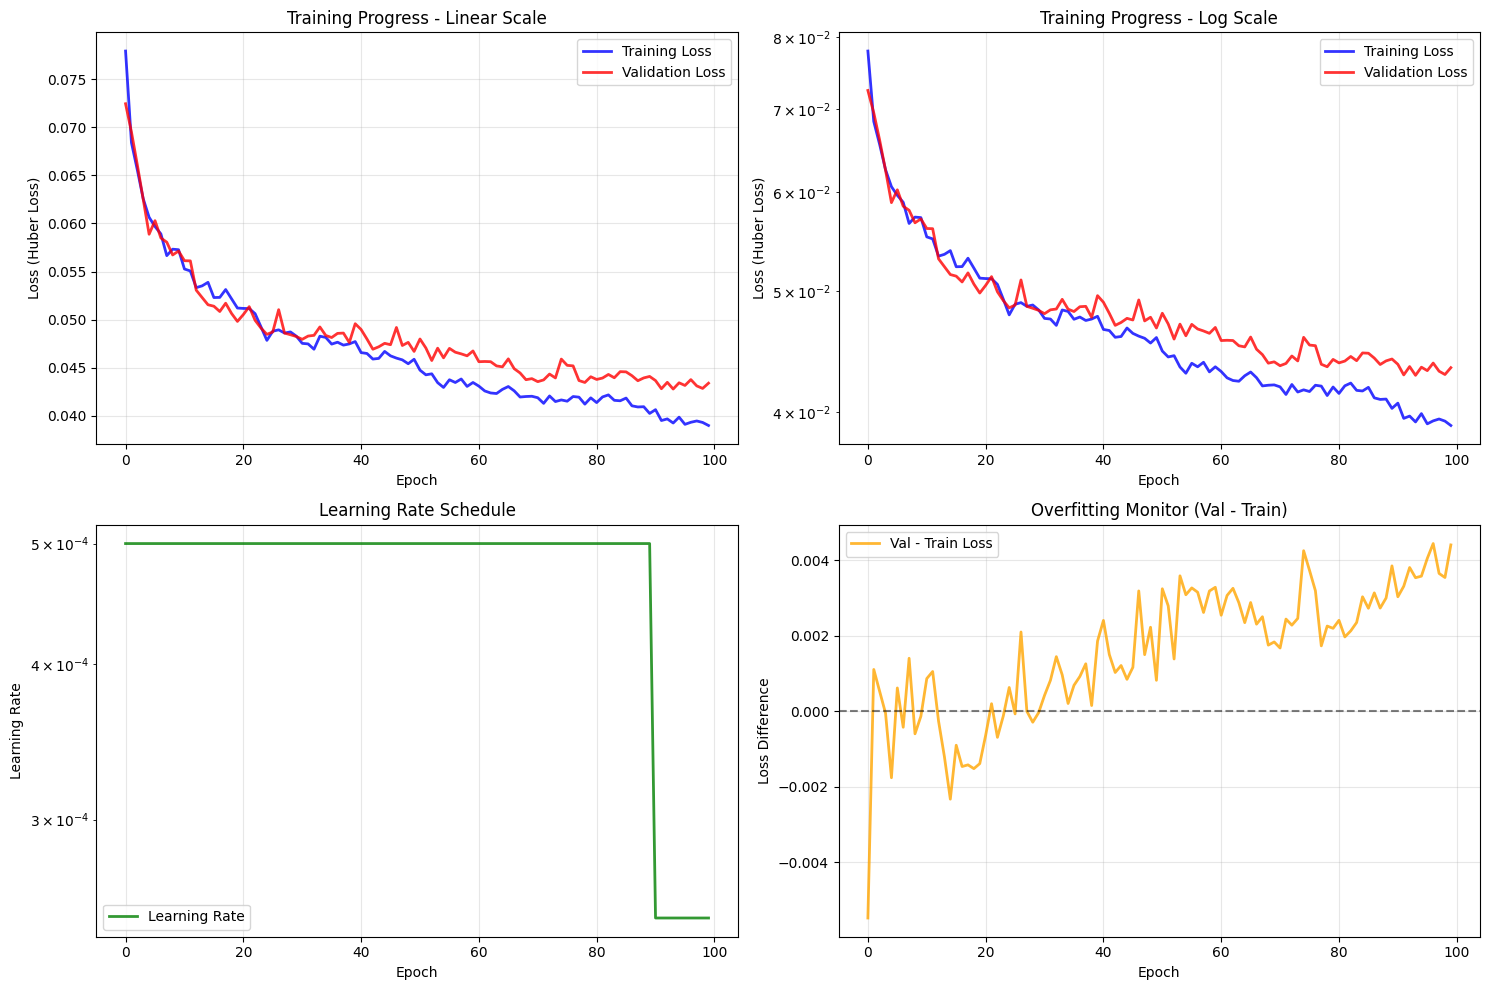

In [36]:
plt.figure(figsize=(15, 10))

# Plot 1: Training Progress (Linear Scale)
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8, linewidth=2, color='blue')
plt.plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber Loss)')
plt.title('Training Progress - Linear Scale')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training Progress (Log Scale)
plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Training Loss', alpha=0.8, linewidth=2, color='blue')
plt.plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber Loss)')
plt.title('Training Progress - Log Scale')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
plt.subplot(2, 2, 3)
learning_rates = training_history['learning_rates']
plt.plot(learning_rates, label='Learning Rate', alpha=0.8, linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Loss Difference (Overfitting Detection)
plt.subplot(2, 2, 4)
loss_diff = [val - train for train, val in zip(train_losses, val_losses)]
plt.plot(loss_diff, label='Val - Train Loss', alpha=0.8, linewidth=2, color='orange')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Overfitting Monitor (Val - Train)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [37]:
# Detailed final metrics
print(f"\n📈 DETAILED METRICS:")
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")
print(f"Loss difference (Val-Train): {val_losses[-1] - train_losses[-1]:+.6f}")
print(f"Best epoch: {training_history['best_model_state']['epoch'] + 1}")
print(f"Final learning rate: {learning_rates[-1]:.2e}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")


📈 DETAILED METRICS:
Final training loss: 0.038994
Final validation loss: 0.043395
Loss difference (Val-Train): +0.004401
Best epoch: 94
Final learning rate: 2.50e-04
Loss reduction: 50.0%


# CELL 13: Model Evaluation on Test Set

In [38]:
# Cell 1: Imports and Setup
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

print("📦 Imports loaded successfully!")
print("🔧 Setting up evaluation environment...")

📦 Imports loaded successfully!
🔧 Setting up evaluation environment...


In [39]:
# Cell 2: Model Prediction Function
def get_model_predictions(model, test_data, device=None, batch_size=256):
    """
    Get predictions from model with batch processing
    """
    print("🔍 GETTING MODEL PREDICTIONS")
    print("=" * 50)
    
    # Set device
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_predictions = []
    all_targets = []
    all_embeddings = []
    
    with torch.no_grad():
        # Get test data
        test_sequences = test_data['sequences']
        test_returns = test_data['returns'] 
        test_targets = test_data['targets']
        
        print(f"Test samples: {len(test_sequences):,}")
        print(f"Sequence length: {test_sequences.shape[1]}")
        print(f"Features: {test_sequences.shape[2]}")
        
        # Process in batches
        n_batches = len(test_sequences) // batch_size + 1
        print(f"Processing {n_batches} batches...")
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(test_sequences))
            
            if start_idx >= len(test_sequences):
                break
                
            # Get batch
            batch_sequences = test_sequences[start_idx:end_idx].to(device)
            batch_returns = test_returns[start_idx:end_idx].to(device)
            batch_targets = test_targets[start_idx:end_idx].to(device)
            
            # Get predictions
            pred_volatility = model(batch_sequences, batch_returns)
            all_predictions.append(pred_volatility.squeeze(-1).cpu())
            all_targets.append(batch_targets.cpu())
            
            # Get embeddings if available
            try:
                embeddings = model(batch_sequences, batch_returns, return_embeddings=True)
                all_embeddings.append(embeddings.cpu())
            except:
                pass
            
            if (i + 1) % 10 == 0:
                print(f"  Processed batch {i+1}/{n_batches}")
        
        # Concatenate all results
        pred_vol_tensor = torch.cat(all_predictions, dim=0)
        true_vol_tensor = torch.cat(all_targets, dim=0)
        
        pred_vol_numpy = pred_vol_tensor.numpy()
        true_vol_numpy = true_vol_tensor.numpy()
        
        # Get embeddings if available
        embeddings_numpy = None
        if all_embeddings:
            embeddings_tensor = torch.cat(all_embeddings, dim=0)
            embeddings_numpy = embeddings_tensor.numpy()
    
    print("✅ Predictions completed!")
    print(f"Generated {len(pred_vol_numpy):,} predictions")
    
    return pred_vol_numpy, true_vol_numpy, embeddings_numpy

# Get predictions
pred_vol_numpy, true_vol_numpy, embeddings_numpy = get_model_predictions(model, test_data)

🔍 GETTING MODEL PREDICTIONS
Test samples: 483
Sequence length: 48
Features: 51
Processing 2 batches...
✅ Predictions completed!
Generated 483 predictions


In [40]:
# Cell 3: Calculate Basic Metrics
def calculate_basic_metrics(true_values, pred_values):
    """Calculate basic regression metrics"""
    
    print("📊 CALCULATING BASIC METRICS...")
    print("-" * 40)
    
    # Basic regression metrics
    mse = mean_squared_error(true_values, pred_values)
    mae = mean_absolute_error(true_values, pred_values)
    rmse = np.sqrt(mse)
    
    # R-squared
    ss_res = np.sum((true_values - pred_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Percentage Error (MAPE)
    non_zero_mask = true_values != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((true_values[non_zero_mask] - pred_values[non_zero_mask]) 
                             / true_values[non_zero_mask])) * 100
    else:
        mape = np.inf
    
    # Correlation metrics
    correlation = np.corrcoef(pred_values, true_values)[0, 1]
    spearman_corr, _ = stats.spearmanr(pred_values, true_values)
    
    print("📈 BASIC METRICS:")
    print(f"  RMSE:                {rmse:.6f}")
    print(f"  MAE:                 {mae:.6f}")
    print(f"  MAPE:                {mape:.2f}%")
    print(f"  R²:                  {r_squared:.4f}")
    print(f"  Pearson Correlation: {correlation:.4f}")
    print(f"  Spearman Correlation:{spearman_corr:.4f}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r_squared': r_squared,
        'correlation': correlation,
        'spearman_correlation': spearman_corr,
        'mse': mse
    }

# Calculate basic metrics
basic_metrics = calculate_basic_metrics(true_vol_numpy, pred_vol_numpy)

📊 CALCULATING BASIC METRICS...
----------------------------------------
📈 BASIC METRICS:
  RMSE:                0.614315
  MAE:                 0.481108
  MAPE:                123.64%
  R²:                  0.6205
  Pearson Correlation: 0.8522
  Spearman Correlation:0.6971


In [41]:
# Cell 4: Calculate Volatility-Specific Metrics
def calculate_volatility_metrics(true_values, pred_values):
    """Calculate volatility-specific metrics"""
    
    print("📊 CALCULATING VOLATILITY-SPECIFIC METRICS...")
    print("-" * 50)
    
    # Directional accuracy (for volatility changes)
    if len(true_values) > 1:
        true_direction = np.diff(true_values) > 0
        pred_direction = np.diff(pred_values) > 0
        directional_accuracy = np.mean(true_direction == pred_direction) * 100
    else:
        directional_accuracy = 0
    
    # Volatility clustering detection
    true_vol_changes = np.abs(np.diff(true_values))
    pred_vol_changes = np.abs(np.diff(pred_values))
    clustering_corr = np.corrcoef(true_vol_changes, pred_vol_changes)[0, 1]
    
    # Extreme value prediction accuracy (top/bottom 10%)
    true_vol_percentiles = np.percentile(true_values, [10, 90])
    extreme_mask = (true_values <= true_vol_percentiles[0]) | (true_values >= true_vol_percentiles[1])
    
    if np.sum(extreme_mask) > 0:
        extreme_mse = mean_squared_error(true_values[extreme_mask], pred_values[extreme_mask])
        extreme_rmse = np.sqrt(extreme_mse)
        extreme_corr = np.corrcoef(true_values[extreme_mask], pred_values[extreme_mask])[0, 1]
        extreme_samples = np.sum(extreme_mask)
    else:
        extreme_rmse = np.nan
        extreme_corr = np.nan
        extreme_samples = 0
    
    print("📊 VOLATILITY-SPECIFIC METRICS:")
    print(f"  Directional Accuracy:   {directional_accuracy:.1f}%")
    print(f"  Clustering Correlation: {clustering_corr:.4f}")
    print(f"  Extreme Values RMSE:    {extreme_rmse:.6f}")
    print(f"  Extreme Values Corr:    {extreme_corr:.4f}")
    print(f"  Extreme Samples:        {extreme_samples:,} ({extreme_samples/len(true_values)*100:.1f}%)")
    
    return {
        'directional_accuracy': directional_accuracy,
        'clustering_correlation': clustering_corr,
        'extreme_rmse': extreme_rmse,
        'extreme_correlation': extreme_corr,
        'extreme_samples': extreme_samples
    }

# Calculate volatility-specific metrics
vol_metrics = calculate_volatility_metrics(true_vol_numpy, pred_vol_numpy)

📊 CALCULATING VOLATILITY-SPECIFIC METRICS...
--------------------------------------------------
📊 VOLATILITY-SPECIFIC METRICS:
  Directional Accuracy:   78.2%
  Clustering Correlation: 0.8124
  Extreme Values RMSE:    0.936225
  Extreme Values Corr:    0.9196
  Extreme Samples:        98 (20.3%)


In [42]:
# Cell 5: Data Statistics Summary
def calculate_data_statistics(true_values, pred_values):
    """Calculate comprehensive data statistics"""
    
    print("📋 DATA STATISTICS SUMMARY")
    print("=" * 50)
    
    residuals = pred_values - true_values
    
    stats_dict = {
        'n_samples': len(true_values),
        'true_mean': np.mean(true_values),
        'pred_mean': np.mean(pred_values),
        'true_std': np.std(true_values),
        'pred_std': np.std(pred_values),
        'true_min': np.min(true_values),
        'pred_min': np.min(pred_values),
        'true_max': np.max(true_values),
        'pred_max': np.max(pred_values),
        'residual_mean': np.mean(residuals),
        'residual_std': np.std(residuals)
    }
    
    print(f"📊 SAMPLE STATISTICS:")
    print(f"  Test samples:          {stats_dict['n_samples']:,}")
    print(f"  Mean true volatility:  {stats_dict['true_mean']:.6f}")
    print(f"  Mean pred volatility:  {stats_dict['pred_mean']:.6f}")
    print(f"  Bias (pred - true):    {stats_dict['pred_mean'] - stats_dict['true_mean']:+.6f}")
    
    print(f"\n📈 VARIABILITY:")
    print(f"  Std true volatility:   {stats_dict['true_std']:.6f}")
    print(f"  Std pred volatility:   {stats_dict['pred_std']:.6f}")
    print(f"  Residual std:          {stats_dict['residual_std']:.6f}")
    
    print(f"\n📊 RANGE:")
    print(f"  True range:            {stats_dict['true_min']:.6f} - {stats_dict['true_max']:.6f}")
    print(f"  Pred range:            {stats_dict['pred_min']:.6f} - {stats_dict['pred_max']:.6f}")
    
    return stats_dict, residuals

# Calculate statistics
data_stats, residuals = calculate_data_statistics(true_vol_numpy, pred_vol_numpy)

📋 DATA STATISTICS SUMMARY
📊 SAMPLE STATISTICS:
  Test samples:          483
  Mean true volatility:  0.047620
  Mean pred volatility:  0.353468
  Bias (pred - true):    +0.305847

📈 VARIABILITY:
  Std true volatility:   0.997190
  Std pred volatility:   0.741870
  Residual std:          0.532767

📊 RANGE:
  True range:            -1.578125 - 5.240195
  Pred range:            0.000001 - 4.840901


🎨 CREATING PREDICTION AND RESIDUAL PLOTS...


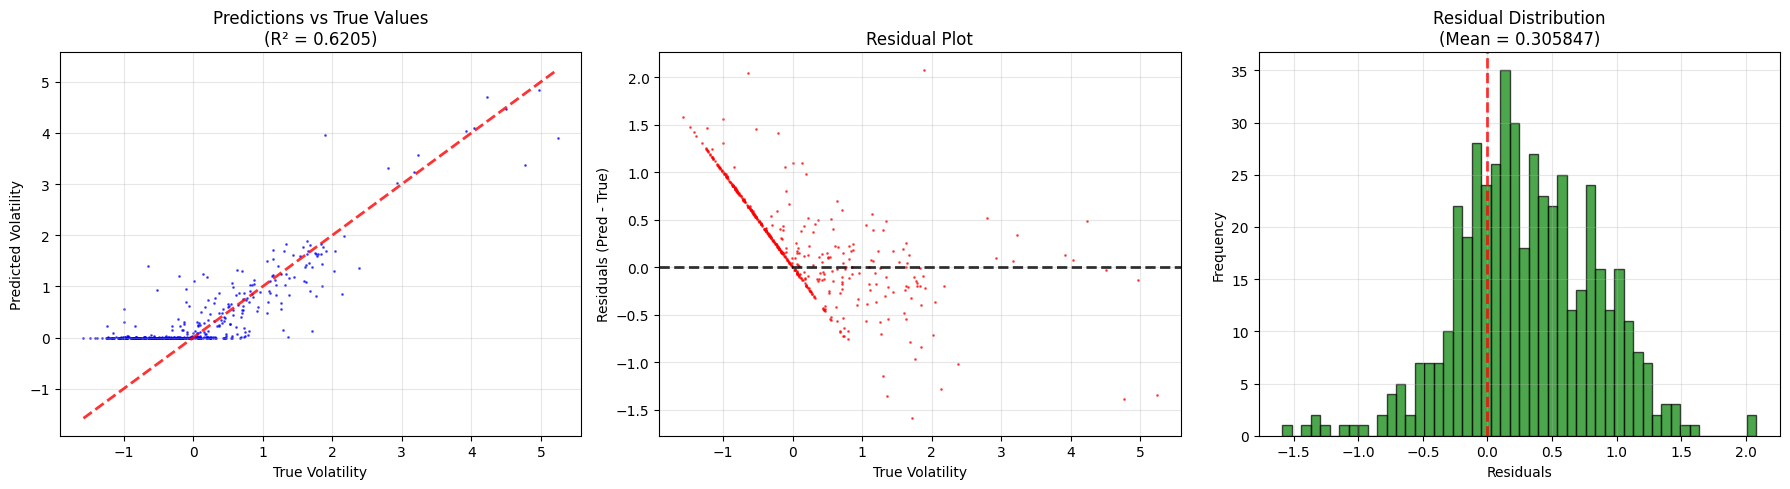

In [43]:
# Cell 6: Visualization Plots (Part 1)
def plot_predictions_and_residuals(true_values, pred_values, r_squared, mae):
    """Create prediction scatter plot and residual analysis"""
    
    print("🎨 CREATING PREDICTION AND RESIDUAL PLOTS...")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Predictions vs True Values
    axes[0].scatter(true_values, pred_values, alpha=0.6, s=1, color='blue')
    min_val = min(true_values.min(), pred_values.min())
    max_val = max(true_values.max(), pred_values.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    axes[0].set_xlabel('True Volatility')
    axes[0].set_ylabel('Predicted Volatility')
    axes[0].set_title(f'Predictions vs True Values\n(R² = {r_squared:.4f})')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals vs True Values
    residuals = pred_values - true_values
    axes[1].scatter(true_values, residuals, alpha=0.6, s=1, color='red')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
    axes[1].set_xlabel('True Volatility')
    axes[1].set_ylabel('Residuals (Pred - True)')
    axes[1].set_title('Residual Plot')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Residual Distribution
    axes[2].hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[2].axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
    axes[2].set_xlabel('Residuals')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title(f'Residual Distribution\n(Mean = {np.mean(residuals):.6f})')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return residuals

# Create prediction and residual plots
residuals = plot_predictions_and_residuals(true_vol_numpy, pred_vol_numpy, 
                                         basic_metrics['r_squared'], basic_metrics['mae'])

🎨 CREATING TIME SERIES AND DISTRIBUTION PLOTS...


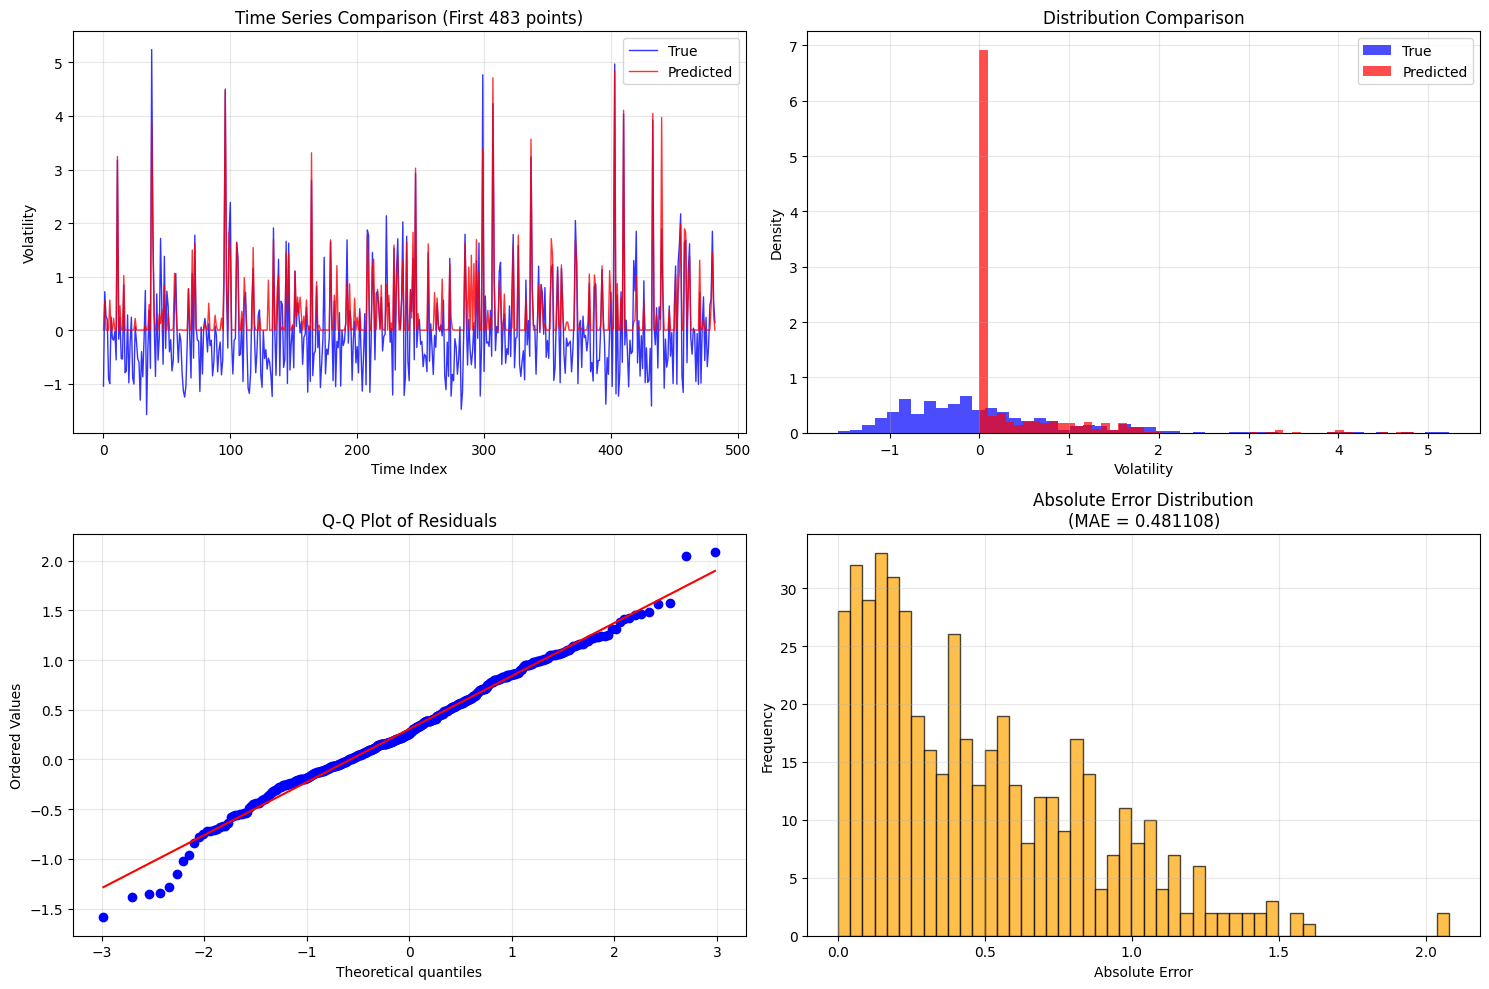

In [44]:
# Cell 7: Visualization Plots (Part 2)
def plot_time_series_and_distributions(true_values, pred_values, plot_length=1000):
    """Create time series and distribution comparison plots"""
    
    print("🎨 CREATING TIME SERIES AND DISTRIBUTION PLOTS...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Time Series Comparison
    plot_len = min(plot_length, len(true_values))
    axes[0,0].plot(true_values[:plot_len], label='True', alpha=0.8, linewidth=1, color='blue')
    axes[0,0].plot(pred_values[:plot_len], label='Predicted', alpha=0.8, linewidth=1, color='red')
    axes[0,0].set_xlabel('Time Index')
    axes[0,0].set_ylabel('Volatility')
    axes[0,0].set_title(f'Time Series Comparison (First {plot_len} points)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Distribution Comparison
    axes[0,1].hist(true_values, bins=50, alpha=0.7, label='True', density=True, color='blue')
    axes[0,1].hist(pred_values, bins=50, alpha=0.7, label='Predicted', density=True, color='red')
    axes[0,1].set_xlabel('Volatility')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title('Distribution Comparison')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Q-Q Plot of Residuals
    residuals = pred_values - true_values
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot of Residuals')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Absolute Error Distribution
    absolute_errors = np.abs(residuals)
    axes[1,1].hist(absolute_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].set_xlabel('Absolute Error')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title(f'Absolute Error Distribution\n(MAE = {np.mean(absolute_errors):.6f})')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create time series and distribution plots
plot_time_series_and_distributions(true_vol_numpy, pred_vol_numpy)

In [45]:
# Cell 8: Final Results Summary
def create_final_summary(basic_metrics, vol_metrics, data_stats):
    """Create comprehensive final evaluation summary"""
    
    print("\n" + "="*70)
    print("🎯 COMPREHENSIVE MODEL EVALUATION SUMMARY")
    print("="*70)
    
    print("\n📊 PERFORMANCE METRICS:")
    print(f"  Root Mean Square Error (RMSE):    {basic_metrics['rmse']:.6f}")
    print(f"  Mean Absolute Error (MAE):        {basic_metrics['mae']:.6f}")
    print(f"  Mean Absolute Percentage Error:   {basic_metrics['mape']:.2f}%")
    print(f"  R-squared (R²):                   {basic_metrics['r_squared']:.4f}")
    
    print(f"\n🔗 CORRELATION ANALYSIS:")
    print(f"  Pearson Correlation:              {basic_metrics['correlation']:.4f}")
    print(f"  Spearman Correlation:             {basic_metrics['spearman_correlation']:.4f}")
    print(f"  Directional Accuracy:             {vol_metrics['directional_accuracy']:.1f}%")
    
    print(f"\n📈 VOLATILITY-SPECIFIC METRICS:")
    print(f"  Volatility Clustering Correlation: {vol_metrics['clustering_correlation']:.4f}")
    print(f"  Extreme Values RMSE:              {vol_metrics['extreme_rmse']:.6f}")
    print(f"  Extreme Values Correlation:       {vol_metrics['extreme_correlation']:.4f}")
    print(f"  Extreme Value Samples:            {vol_metrics['extreme_samples']:,}")
    
    print(f"\n📋 DATA SUMMARY:")
    print(f"  Total Test Samples:               {data_stats['n_samples']:,}")
    print(f"  Prediction Bias:                  {data_stats['pred_mean'] - data_stats['true_mean']:+.6f}")
    print(f"  Residual Standard Deviation:      {data_stats['residual_std']:.6f}")
    
    # Performance assessment
    print(f"\n🏆 PERFORMANCE ASSESSMENT:")
    
    # R² assessment
    if basic_metrics['r_squared'] >= 0.8:
        r2_assessment = "Excellent"
    elif basic_metrics['r_squared'] >= 0.6:
        r2_assessment = "Good"
    elif basic_metrics['r_squared'] >= 0.4:
        r2_assessment = "Fair"
    else:
        r2_assessment = "Needs Improvement"
    
    # Correlation assessment
    if basic_metrics['correlation'] >= 0.9:
        corr_assessment = "Excellent"
    elif basic_metrics['correlation'] >= 0.7:
        corr_assessment = "Good"
    elif basic_metrics['correlation'] >= 0.5:
        corr_assessment = "Fair"
    else:
        corr_assessment = "Needs Improvement"
    
    # Directional accuracy assessment
    if vol_metrics['directional_accuracy'] >= 60:
        dir_assessment = "Good"
    elif vol_metrics['directional_accuracy'] >= 55:
        dir_assessment = "Fair"
    else:
        dir_assessment = "Needs Improvement"
    
    print(f"  R² Score:                         {r2_assessment} ({basic_metrics['r_squared']:.4f})")
    print(f"  Correlation:                      {corr_assessment} ({basic_metrics['correlation']:.4f})")
    print(f"  Directional Accuracy:             {dir_assessment} ({vol_metrics['directional_accuracy']:.1f}%)")
    
    print("="*70)
    
    # Create comprehensive results dictionary
    final_results = {
        'predictions': pred_vol_numpy,
        'true_values': true_vol_numpy,
        'embeddings': embeddings_numpy,
        'residuals': residuals,
        'metrics': {**basic_metrics, **vol_metrics},
        'statistics': data_stats,
        'assessment': {
            'r_squared': r2_assessment,
            'correlation': corr_assessment,
            'directional_accuracy': dir_assessment
        }
    }
    
    return final_results

# Create final comprehensive summary
evaluation_results = create_final_summary(basic_metrics, vol_metrics, data_stats)

print("✅ COMPREHENSIVE MODEL EVALUATION COMPLETED!")
print(f"📊 Results stored in 'evaluation_results' dictionary")
print(f"🔍 {len(evaluation_results['predictions']):,} predictions analyzed")


🎯 COMPREHENSIVE MODEL EVALUATION SUMMARY

📊 PERFORMANCE METRICS:
  Root Mean Square Error (RMSE):    0.614315
  Mean Absolute Error (MAE):        0.481108
  Mean Absolute Percentage Error:   123.64%
  R-squared (R²):                   0.6205

🔗 CORRELATION ANALYSIS:
  Pearson Correlation:              0.8522
  Spearman Correlation:             0.6971
  Directional Accuracy:             78.2%

📈 VOLATILITY-SPECIFIC METRICS:
  Volatility Clustering Correlation: 0.8124
  Extreme Values RMSE:              0.936225
  Extreme Values Correlation:       0.9196
  Extreme Value Samples:            98

📋 DATA SUMMARY:
  Total Test Samples:               483
  Prediction Bias:                  +0.305847
  Residual Standard Deviation:      0.532767

🏆 PERFORMANCE ASSESSMENT:
  R² Score:                         Good (0.6205)
  Correlation:                      Good (0.8522)
  Directional Accuracy:             Good (78.2%)
✅ COMPREHENSIVE MODEL EVALUATION COMPLETED!
📊 Results stored in 'evaluation_r

# CELL 14: Visualization of Results

In [46]:
pred_vol = evaluation_results['predictions']
true_vol = evaluation_results['true_values']
embeddings = evaluation_results['embeddings']

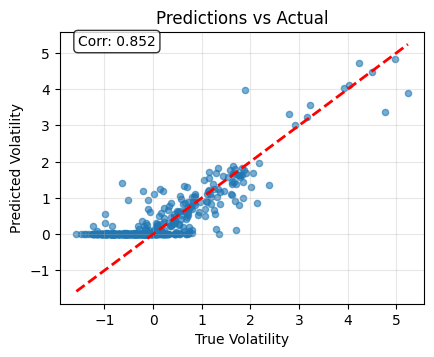

In [47]:
fig = plt.figure(figsize=(16, 12))

# 1. Predictions vs Actual (Scatter)
plt.subplot(3, 3, 1)
plt.scatter(true_vol, pred_vol, alpha=0.6, s=20)
plt.plot([true_vol.min(), true_vol.max()], [true_vol.min(), true_vol.max()], 'r--', lw=2)
plt.xlabel('True Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Predictions vs Actual')
plt.grid(True, alpha=0.3)

# Add correlation text
corr = evaluation_results['metrics']['correlation']
plt.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

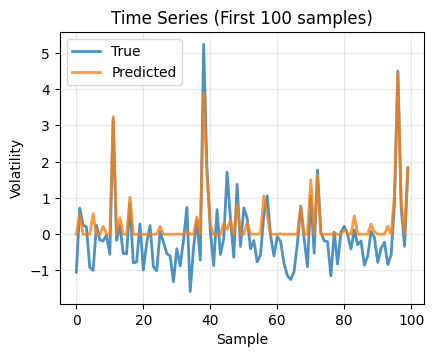

In [48]:
# 2. Time Series Comparison (First 100 samples)
fig = plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 2)
n_show = min(100, len(true_vol))
plt.plot(range(n_show), true_vol[:n_show], label='True', alpha=0.8, linewidth=2)
plt.plot(range(n_show), pred_vol[:n_show], label='Predicted', alpha=0.8, linewidth=2)
plt.xlabel('Sample')
plt.ylabel('Volatility')
plt.title(f'Time Series (First {n_show} samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

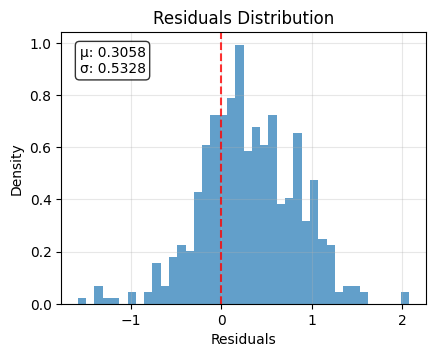

In [49]:
# 3. Residuals Distribution
fig = plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 3)
residuals = pred_vol - true_vol
plt.hist(residuals, bins=40, alpha=0.7, density=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals Distribution')
plt.grid(True, alpha=0.3)

# Add residual stats
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)
plt.text(0.05, 0.95, f'μ: {mean_resid:.4f}\nσ: {std_resid:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

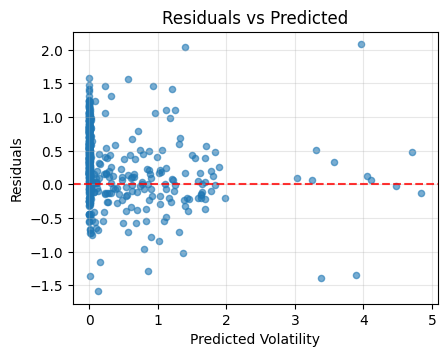

In [50]:
# 4. Residuals vs Predicted
fig = plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 4)
plt.scatter(pred_vol, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Volatility')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)
plt.show()

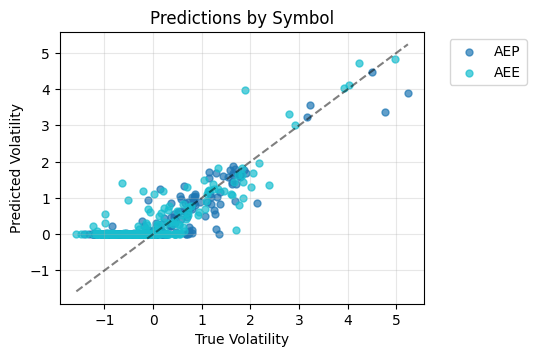

In [51]:
# 5. True vs Predicted by Symbol
fig = plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 5)
test_symbols = test_data['symbols']
unique_symbols = list(set(test_symbols))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_symbols)))

for i, symbol in enumerate(unique_symbols):
    mask = [s == symbol for s in test_symbols]
    plt.scatter(np.array(true_vol)[mask], np.array(pred_vol)[mask], 
               alpha=0.7, label=symbol, color=colors[i], s=25)

plt.plot([true_vol.min(), true_vol.max()], [true_vol.min(), true_vol.max()], 'k--', alpha=0.5)
plt.xlabel('True Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Predictions by Symbol')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
# Extract results safely
pred_vol = evaluation_results['predictions']
true_vol = evaluation_results['true_values']
embeddings = evaluation_results['embeddings']

print(f"Predictions shape: {pred_vol.shape}")
print(f"True values shape: {true_vol.shape}")
print(f"Embeddings: {type(embeddings)}")

Predictions shape: (483,)
True values shape: (483,)
Embeddings: <class 'NoneType'>


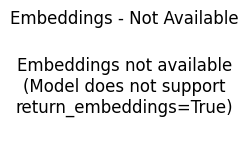

In [53]:
# 6. Embedding Visualization (PCA)
plt.subplot(3, 3, 6)
if embeddings is not None and hasattr(embeddings, 'shape'):
    print(f"Embeddings shape: {embeddings.shape}")
    
    try:
        if len(embeddings.shape) == 3 and embeddings.shape[-1] > 2:
            # Use last timestep embeddings for visualization
            last_timestep_embeddings = embeddings[:, -1, :]  # Shape: (n_samples, hidden_size)
            
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(last_timestep_embeddings)
            
            scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=true_vol, cmap='viridis', alpha=0.7, s=25)
            plt.colorbar(scatter, label='True Volatility')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
            plt.title('Embeddings (PCA Projection)')
            plt.grid(True, alpha=0.3)
            
        elif len(embeddings.shape) == 2 and embeddings.shape[-1] > 2:
            # 2D embeddings - already flattened
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)
            
            scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=true_vol, cmap='viridis', alpha=0.7, s=25)
            plt.colorbar(scatter, label='True Volatility')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
            plt.title('Embeddings (PCA Projection)')
            plt.grid(True, alpha=0.3)
            
        elif len(embeddings.shape) >= 2 and embeddings.shape[-1] == 2:
            # Already 2D - no PCA needed
            if len(embeddings.shape) == 3:
                embeddings_2d = embeddings[:, -1, :]  # Use last timestep
            else:
                embeddings_2d = embeddings
                
            scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=true_vol, cmap='viridis', alpha=0.7, s=25)
            plt.colorbar(scatter, label='True Volatility')
            plt.xlabel('Embedding Dim 1')
            plt.ylabel('Embedding Dim 2')
            plt.title('Embeddings (2D)')
            plt.grid(True, alpha=0.3)
        else:
            # Can't visualize
            plt.text(0.5, 0.5, f'Embeddings not suitable\nfor visualization\nShape: {embeddings.shape}', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Embeddings - N/A')
            
    except Exception as e:
        plt.text(0.5, 0.5, f'Error visualizing embeddings:\n{str(e)}', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Embeddings - Error')
else:
    # No embeddings available
    plt.text(0.5, 0.5, 'Embeddings not available\n(Model does not support\nreturn_embeddings=True)', 
            ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Embeddings - Not Available')
    plt.axis('off')

plt.show()

# fix this

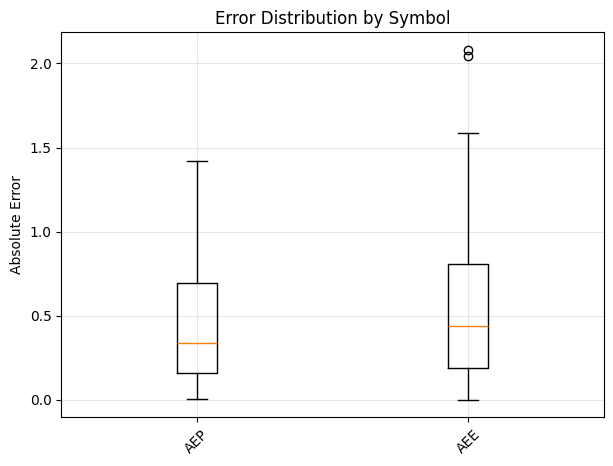

In [54]:
# 7. Error Distribution by Symbol
fig = plt.figure(figsize=(7, 5))
# plt.subplot(3, 3, 7)
symbol_errors = {}
for symbol in unique_symbols:
    mask = [s == symbol for s in test_symbols]
    symbol_errors[symbol] = np.abs(np.array(pred_vol)[mask] - np.array(true_vol)[mask])

plt.boxplot([symbol_errors[symbol] for symbol in unique_symbols], 
           labels=unique_symbols)
plt.ylabel('Absolute Error')
plt.title('Error Distribution by Symbol')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

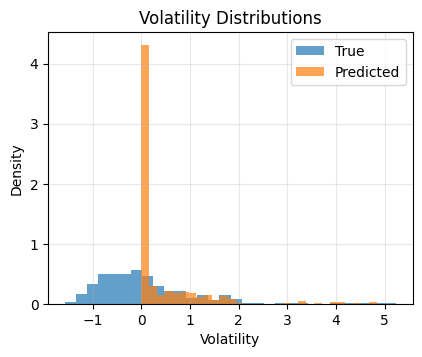

In [55]:
# 8. Volatility Distribution
fig = plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 8)
plt.hist(true_vol, bins=30, alpha=0.7, label='True', density=True)
plt.hist(pred_vol, bins=30, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.title('Volatility Distributions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

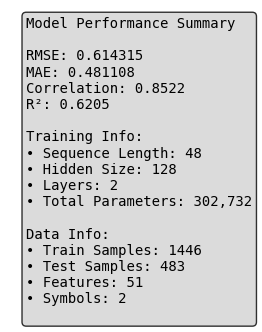

In [56]:
# 9. Model Performance Summary
plt.subplot(3, 3, 9)
plt.axis('off')
metrics = evaluation_results['metrics']
summary_text = f"""Model Performance Summary

RMSE: {metrics['rmse']:.6f}
MAE: {metrics['mae']:.6f}
Correlation: {metrics['correlation']:.4f}
R²: {metrics['r_squared']:.4f}

Training Info:
• Sequence Length: {SEQUENCE_LENGTH}
• Hidden Size: {HIDDEN_SIZE}
• Layers: {NUM_LAYERS}
• Total Parameters: {total_params:,}

Data Info:
• Train Samples: {len(train_data['sequences'])}
• Test Samples: {len(test_data['sequences'])}
• Features: {INPUT_SIZE}
• Symbols: {len(unique_symbols)}
"""

plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()